#### _ALL Python imports (split when notebook gets split)_

In [627]:
import requests
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import sentiment_analyzer, vader, SentimentAnalyzer, SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from transformers import pipeline

%config InlineBackend.figure_format = 'retina'

#### _Setting up colormap for graphics_

In [177]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['#EBECF0','#b2a3af','#ff355e']  # R -> G -> B
cmap_name = 'pnkgry'

pnkgry = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

# PART 1: Data Harvesting

**IMPORTS!!!**

In [ ]:
url_submissions = 'https://api.pushshift.io/reddit/search/submission'
url_comments = 'https://api.pushshift.io/reddit/search/comment'

### Getting data from Ask Men Subreddit ###

In [ ]:
AM_posts_cols = ['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'removed_by_category', 'retrieved_on', 'score', 'selftext',
       'send_replies', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_subscribers', 'subreddit_type', 'thumbnail', 'title',
       'total_awards_received', 'treatment_tags', 'upvote_ratio', 'url',
       'whitelist_status', 'wls', 'post_hint', 'preview',
       'author_flair_background_color', 'author_flair_text_color',
       'banned_by']

In [ ]:
AM_posts_df = pd.DataFrame()#columns = AM_posts_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_submissions, params = {'subreddit': 'AskMen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AM_posts_df = pd.concat([AM_posts_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

In [ ]:
AM_posts_df.shape

In [ ]:
AM_posts_df['title_selftext'] = AM_posts_df['title']+AM_posts_df['selftext']
AM_posts_df[['title_selftext', 'title', 'selftext']].head()

In [ ]:
AM_comments_cols = ['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'gildings', 'id', 'is_submitter', 'link_id', 'locked',
       'no_follow', 'parent_id', 'permalink', 'retrieved_on', 'score',
       'send_replies', 'stickied', 'subreddit', 'subreddit_id',
       'top_awarded_type', 'total_awards_received', 'treatment_tags',
       'distinguished']

In [ ]:
AM_comments_df = pd.DataFrame(columns = AM_comments_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_comments, params = {'subreddit': 'AskMen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AM_comments_df = pd.concat([AM_comments_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

In [5]:
AM_comments_df.shape

(1800, 41)

### Getting data from AskWomen Subreddit ###

In [ ]:
resp = requests.get(url_submissions, params = {'subreddit': 'AskWomen','size': 100,'before': before_params[-1]})
pd.DataFrame(resp.json()['data']).columns

In [ ]:
AW_posts_cols = ['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'removed_by_category', 'retrieved_on', 'score',
       'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit',
       'subreddit_id', 'subreddit_subscribers', 'subreddit_type',
       'suggested_sort', 'thumbnail', 'title', 'total_awards_received',
       'treatment_tags', 'upvote_ratio', 'url', 'whitelist_status', 'wls',
       'author_flair_template_id', 'author_flair_text_color']

In [ ]:
AW_posts_df = pd.DataFrame(columns = AW_posts_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_submissions, params = {'subreddit': 'AskWomen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AW_posts_df = pd.concat([AW_posts_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

In [4]:
AW_posts_df.shape

(2000, 72)

In [ ]:
AW_posts_df['title_selftext'] = AW_posts_df['title']+AW_posts_df['selftext']
AW_posts_df[['title_selftext', 'title', 'selftext']].head()

In [ ]:
AW_comments_cols = ['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'distinguished', 'gildings', 'id', 'is_submitter',
       'link_id', 'locked', 'no_follow', 'parent_id', 'permalink',
       'retrieved_on', 'score', 'send_replies', 'stickied', 'subreddit',
       'subreddit_id', 'top_awarded_type', 'total_awards_received',
       'treatment_tags']

In [ ]:
AW_comments_df = pd.DataFrame(columns = AW_comments_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_comments, params = {'subreddit': 'AskWomen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AW_comments_df = pd.concat([AW_comments_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

In [3]:
AW_comments_df.shape

(1700, 41)

In [ ]:
AW_comments_df['body']

#### Exporting harvested data to csv files for retrieval in subsequent parts

In [536]:
AW_comments_df.to_csv('aw_com.csv')
AW_posts_df.to_csv('aw_pos.csv')
AM_comments_df.to_csv('am_com.csv')
AM_posts_df.to_csv('am_pos.csv')

# PART 2: Data Cleaning

**PYTHON IMPORTS!!!**

#### Retrieving data harvested in step 1 from csv files to dataframes

In [192]:
AW_comments_df = pd.read_csv('aw_com.csv')
AW_posts_df = pd.read_csv('aw_pos.csv')
AM_comments_df = pd.read_csv('am_com.csv')
AM_posts_df = pd.read_csv('am_pos.csv')

### Handling "noise" in data identified through visual inspection of raw data, tokens, and ngrams

In [19]:
def clean_garbage():
    regexps = [r'\\+', r'\\n+', r'\\r+', r'http\S+', r'"+', r"'+", r"__+",r"--+", r"==+", r'\d+', r'/r\S+', r'\u200d', r'“+',r'”+']
    trash = ['[removed]', '(', ')', 'removed', '_', '*']
    for regexp in regexps:
        AM_posts_df['title_selftext'] = AM_posts_df['title_selftext'].apply(lambda x: re.sub(regexp, "", str(x), 0, re.MULTILINE))
        AW_posts_df['title_selftext'] = AW_posts_df['title_selftext'].apply(lambda x: re.sub(regexp, "", str(x), 0, re.MULTILINE))
        AM_comments_df['body'] = AM_comments_df['body'].apply(lambda x: re.sub(regexp, "", str(x), 0, re.MULTILINE))
        AW_comments_df['body'] = AW_comments_df['body'].apply(lambda x: re.sub(regexp, "", str(x), 0, re.MULTILINE))
    for pot in trash:
        AM_posts_df['title_selftext'] = AM_posts_df['title_selftext'].apply(lambda x: x.replace(pot, ""))
        AW_posts_df['title_selftext'] = AW_posts_df['title_selftext'].apply(lambda x: x.replace(pot, ""))
        AM_comments_df['body'] = AM_comments_df['body'].apply(lambda x: x.replace(pot, ""))
        AW_comments_df['body'] = AW_comments_df['body'].apply(lambda x: x.replace(pot, ""))

In [23]:
clean_garbage()


<br>Bigram and trigram analysis (see Part 3) revealed that data includes **messages posted by Reddit moderators**.

In [586]:
print(f"{AW_posts_df['title_selftext'].str.contains('moderator').sum()} posts on AskWomen mention 'moderator'.")
print(f"{AM_posts_df['title_selftext'].str.contains('moderator').sum()} posts on AskMen mention 'moderator'.")
print(f"{AW_comments_df['body'].str.contains('moderator').sum()} comments on AskWomen mention 'moderator'.")
print(f"{AM_comments_df['body'].str.contains('moderator').sum()} comments on AskMen mention 'moderator'.")

3 posts on AskWomen mention 'moderator'.
0 posts on AskMen mention 'moderator'.
0 comments on AskWomen mention 'moderator'.
0 comments on AskMen mention 'moderator'.


In [517]:
pd.options.display.max_columns = 50
AW_comments_df[(AW_comments_df['body'].notna()) & (AW_comments_df['body'].str.contains('moderator'))].head()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1 all_awardings  \
73         1149          1149            1149                49            []   
80          256           256             256                56            []   
94          323           323             323                23            []   
101        1063          1063            1063                63            []   
206         864           864             864                64            []   

     associated_award        author  author_flair_background_color  \
73                NaN       msstark                            NaN   
80                NaN       kaeorin                            NaN   
94                NaN       kaeorin                            NaN   
101               NaN       msstark                            NaN   
206               NaN  spacehusband                            NaN   

    author_flair_css_class author_flair_richtext  \
73                  female                    []   
80                  female                    []   
94                  female                    []   
101                 female                    []   
206                    NaN                    []   

                 author_flair_template_id author_flair_text  \
73   8106c61a-c8aa-11e1-a771-12313b0ce1e2                 ♀   
80                                    NaN                 ♀   
94                                    NaN                 ♀   
101  8106c61a-c8aa-11e1-a771-12313b0ce1e2                 ♀   
206                                   NaN   The modiest mod   

    author_flair_text_color author_flair_type author_fullname  \
73                     dark              text        t2_h1slt   
80                     dark              text        t2_7ys0h   
94                     dark              text        t2_7ys0h   
101                    dark              text        t2_h1slt   
206                    dark              text      t2_2nndgzk   

    author_patreon_flair author_premium awarders  \
73                 False          False       []   
80                 False          False       []   
94                 False          False       []   
101                False          False       []   
206                False          False       []   

                                                  body  \
73   Your submission has been removed:\n\nRemoved f...   
80   Your submission has been removed:\r\n\r\nWe ar...   
94   Your submission has been removed:\r\n\r\nGrace...   
101  Your submission has been removed:\n\nMedical q...   
206  Your submission has been removed:\n\nMedical q...   

     collapsed_because_crowd_control  comment_type  created_utc distinguished  \
73                               NaN           NaN   1609157655     moderator   
80                               NaN           NaN   1609180264     moderator   
94                               NaN           NaN   1609179089     moderator   
101                              NaN           NaN   1609162053     moderator   
206                              NaN           NaN   1609169138     moderator   

    gildings       id  ...    link_id locked  no_follow  parent_id  \
73        {}  gha6jvs  ...  t3_kll4yj  False       True  t3_kll4yj   
80        {}  ghb6wfr  ...  t3_klvy00  False       True  t3_klvy00   
94        {}  ghb4jz5  ...  t3_klvkvm  False       True  t3_klvkvm   
101       {}  ghabg19  ...  t3_klqird  False       True  t3_klqird   
206       {}  ghalrq1  ...  t3_klsfi5  False       True  t3_klsfi5   

                                             permalink retrieved_on  score  \
73   /r/AskWomen/comments/kll4yj/what_would_be_the_...   1609157666      1   
80   /r/AskWomen/comments/klvy00/when_do_you_wear_s...   1609181166      1   
94   /r/AskWomen/comments/klvkvm/why_do_some_women_...   1609179816      1   
101  /r/AskWomen/comments/klqird/women_with_adhd_wh...   1609162064      1   
206  /r/AskWomen/comments/klsfi5/why_am_i_not_pregn...

Comments posted by moderators can be identified using the **`distinguished`** column. Next steps remove those comments from data used in analaysis and models.

In [588]:
AW_comments_df = AW_comments_df[AW_comments_df['distinguished'] != 'moderator']
AW_comments_df = AW_comments_df[AW_comments_df['author'] != 'AutoModerator'] # this may be redundant
AM_comments_df = AM_comments_df[AM_comments_df['author'] != 'AutoModerator'] # this may be redundant
AM_comments_df = AM_comments_df[AM_comments_df['distinguished'] != 'moderator']

/Users/martalew/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [587]:
print(f"{AW_comments_df['body'].str.contains('moderator').sum()} comments on AskWomen mention 'moderator'.")
print(f"{AM_comments_df['body'].str.contains('moderator').sum()} comments on AskMen mention 'moderator'.")

0 comments on AskWomen mention 'moderator'.
0 comments on AskMen mention 'moderator'.


#### Exporting cleaned data to csv files for retrieval in subsequent parts

In [536]:
AW_comments_df.to_csv('aw_com.csv')
AW_posts_df.to_csv('aw_pos.csv')
AM_comments_df.to_csv('am_com.csv')
AM_posts_df.to_csv('am_pos.csv')

# PART 3: Exploratory Analysis

**PYTHON IMPORTS!!!**

#### Retrieving data harvested in step 1 and cleaned in step 2 from csv files to dataframes

In [192]:
AW_comments_df = pd.read_csv('aw_com.csv')
AW_posts_df = pd.read_csv('aw_pos.csv')
AM_comments_df = pd.read_csv('am_com.csv')
AM_posts_df = pd.read_csv('am_pos.csv')

### 3.1 Analysis of length of posts and comments

In [9]:
AM_posts_df['len_chars'] = AM_posts_df['title_selftext'].apply(lambda x: len(str(x)))
AM_posts_df['len_words'] = AM_posts_df['title_selftext'].apply(lambda x: str(x).count(' '))
AM_posts_df['avg_word_chars'] = AM_posts_df['len_chars']/AM_posts_df['len_words']
AW_posts_df['len_chars'] = AW_posts_df['title_selftext'].apply(lambda x: len(str(x)))
AW_posts_df['len_words'] = AW_posts_df['title_selftext'].apply(lambda x: str(x).count(' '))
AW_posts_df['avg_word_chars'] = AW_posts_df['len_chars']/AW_posts_df['len_words']

AM_comments_df['len_chars'] = AM_comments_df['body'].apply(lambda x: len(str(x)))
AM_comments_df['len_words'] = AM_comments_df['body'].apply(lambda x: str(x).count(' '))
AM_comments_df['avg_word_chars'] = AM_comments_df['len_chars']/AM_comments_df['len_words']
AW_comments_df['len_chars'] = AW_comments_df['body'].apply(lambda x: len(str(x)))
AW_comments_df['len_words'] = AW_comments_df['body'].apply(lambda x: str(x).count(' '))
AW_comments_df['avg_word_chars'] = AW_comments_df['len_chars']/AW_comments_df['len_words']

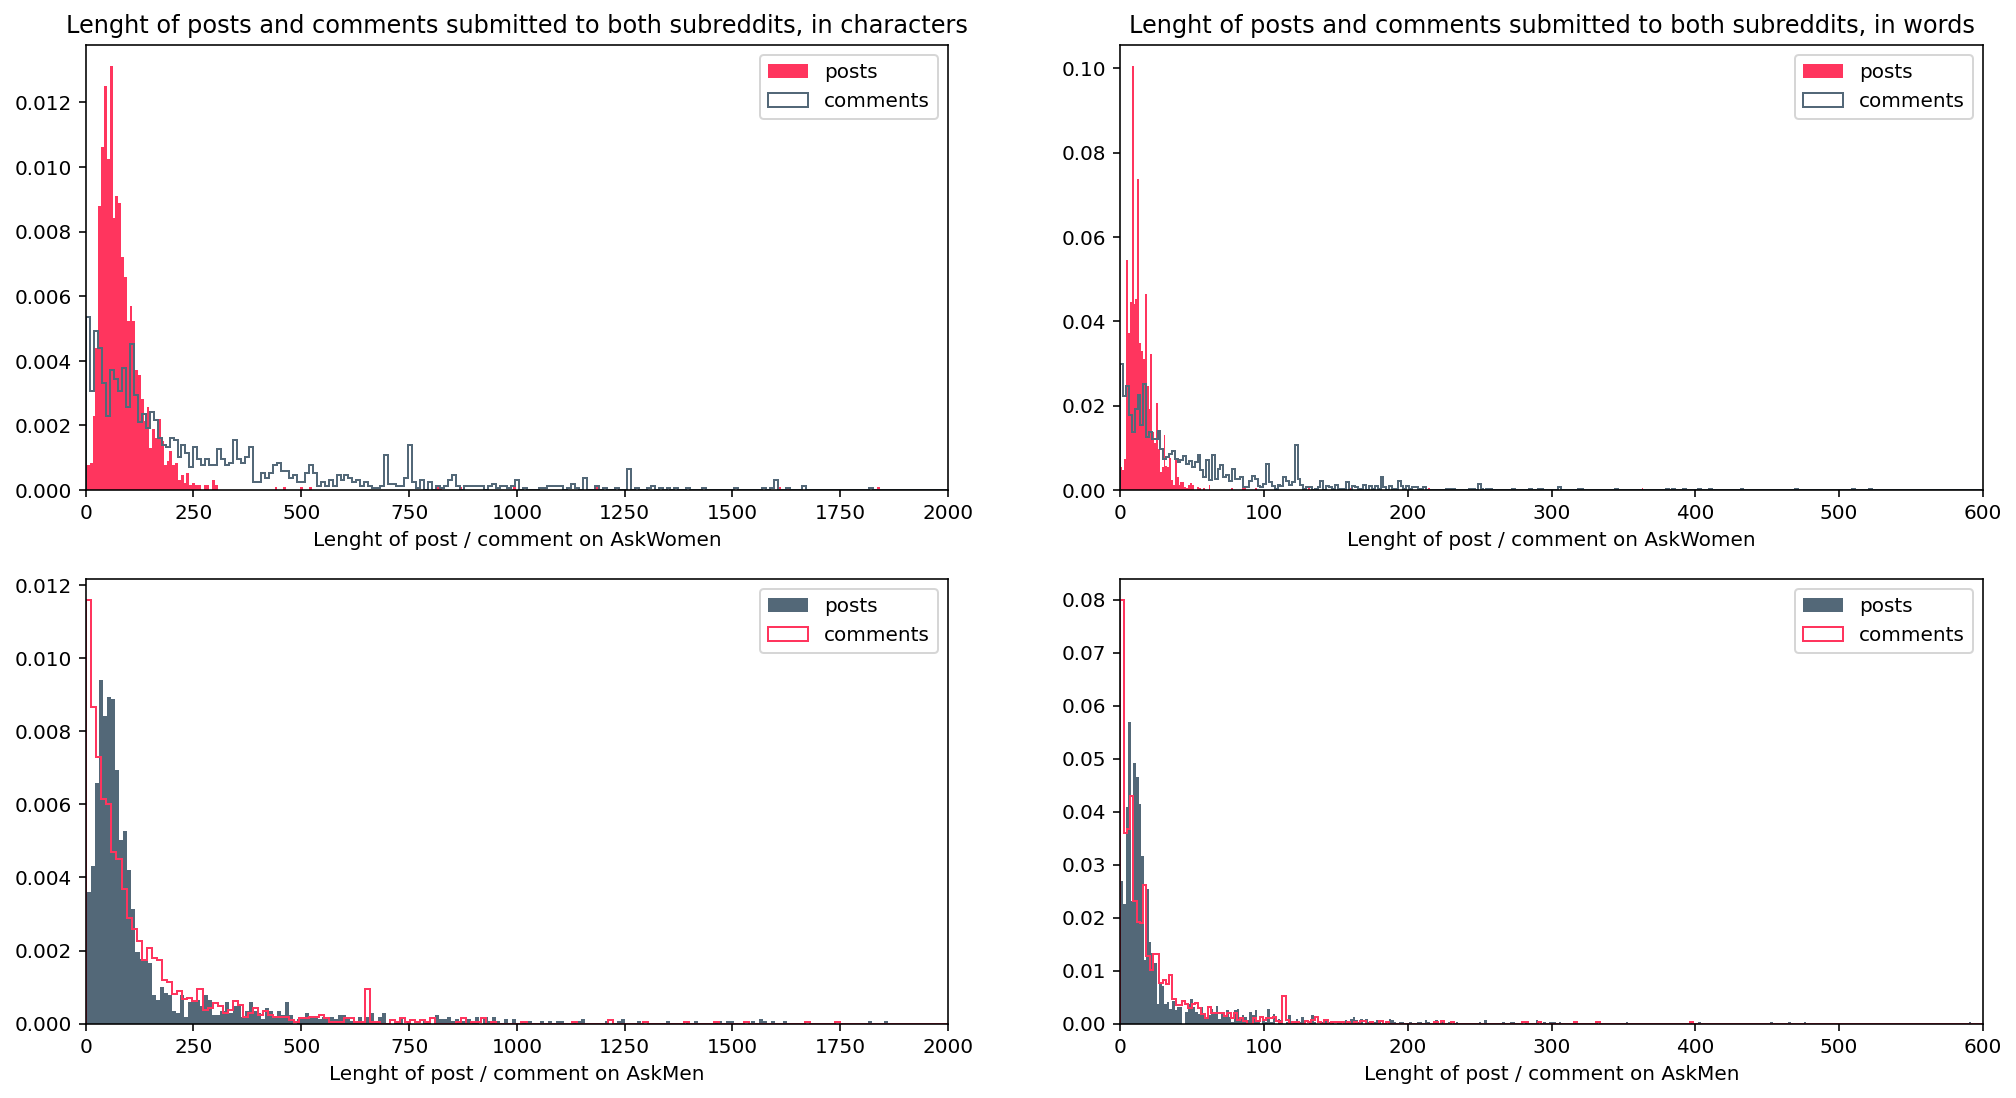

In [210]:
plt.figure(figsize = (17,9))
plt.subplot(2,2,1)
plt.title('Lenght of posts and comments submitted to both subreddits, in characters')
plt.hist(AW_posts_df['len_chars'], color = '#ff355e', label = 'posts', bins = 500, density = True)
plt.hist(AW_comments_df['len_chars'], color = '#536878', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,2000)
plt.xlabel('Lenght of post / comment on AskWomen')
plt.legend()
plt.subplot(2,2,3)
plt.hist(AM_posts_df['len_chars'], color = '#536878', label = 'posts', bins = 500, density = True)
plt.hist(AM_comments_df['len_chars'], color = '#ff355e', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,2000)
plt.xlabel('Lenght of post / comment on AskMen')
plt.legend()
plt.subplot(2,2,2)
plt.title('Lenght of posts and comments submitted to both subreddits, in words')
plt.hist(AW_posts_df['len_words'], color = '#ff355e', label = 'posts', bins = 500, density = True)
plt.hist(AW_comments_df['len_words'], color = '#536878', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,600)
plt.xlabel('Lenght of post / comment on AskWomen')
plt.legend()
plt.subplot(2,2,4)
plt.hist(AM_posts_df['len_words'], color = '#536878', label = 'posts', bins = 500, density = True)
plt.hist(AM_comments_df['len_words'], color = '#ff355e', histtype= 'step', lw = 1, label = 'comments', bins = 500, density = True)
plt.xlim(0,600)
plt.xlabel('Lenght of post / comment on AskMen')
plt.legend();
plt.savefig('./visualizations/lenghts.png')

### 3.2 Analysis of vocabulary (incl. bigrams, trigrams, and emoji)

### Extending the list of stop words to include punctuation

In [53]:
stops = stopwords.words('english')
additions = ["!","?",".",":",";", ",", "\'", "\"","*", "'", '"', "[", ']', '(', ")", '’', '-', '...', '&', '|', '\”']
stops.extend(additions)

In [64]:
'\”' in stops

True

### Creating corpora for AskWomen posts and comments and AskMen posts and comments

In [6]:
AW_comments_corpus = ''
for i in range(len(AW_comments_df)):
    AW_comments_corpus+=str(AW_comments_df.iloc[i,list(AW_comments_df.columns).index('body')])

AM_comments_corpus = ''
for i in range(len(AM_comments_df)):
    AM_comments_corpus+=str(AM_comments_df.iloc[i,list(AM_comments_df.columns).index('body')])

AW_posts_corpus = ''
for i in range(len(AW_posts_df)):
    AW_posts_corpus+=str(AW_posts_df.iloc[i,list(AW_posts_df.columns).index('title_selftext')])
    
AM_posts_corpus = ''
for i in range(len(AM_posts_df)):
    AM_posts_corpus+=str(AM_posts_df.iloc[i,list(AM_posts_df.columns).index('title_selftext')])

In [309]:
dfs = [AW_posts_df, AM_posts_df, AM_comments_df, AW_comments_df]
for df in dfs:
    df['created_yr'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).year)
    df['created_mth'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).month)
    df['created_dy'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).day)
    df['created_hr'] = df['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).replace(tzinfo=datetime.timezone.utc).hour)

In [318]:
#AM_posts_df[['created_yr', 'created_mth', 'created_dy']].describe()
AM_posts_df[['created_yr', 'created_mth', 'created_dy']].agg(['min', 'max'])

created_yr  created_mth  created_dy
min        2020           12          24
max        2020           12          28

_This would have maybe gone further but all the 9000+ entries are from just a few days in December, so it didn't seem interesting_

### 3.3 Sentiment Analysis

#### 3.3.1 Sentiment Analysis using nltk's Sentiment Intensity Analyzer

In [590]:
sia = SentimentIntensityAnalyzer()

In [284]:
AW_posts_df['sia_neg'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AW_posts_df['sia_neu'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AW_posts_df['sia_pos'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['pos'])
AM_posts_df['sia_neg'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AM_posts_df['sia_neu'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AM_posts_df['sia_pos'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

AW_comments_df['sia_neg'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AW_comments_df['sia_neu'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AW_comments_df['sia_pos'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['pos'])
AM_comments_df['sia_neg'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AM_comments_df['sia_neu'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neu'])
AM_comments_df['sia_pos'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

<ipython-input-291-1758c609767f>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AW_comments_df['sia_neg']!=0)]['sia_pos'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')


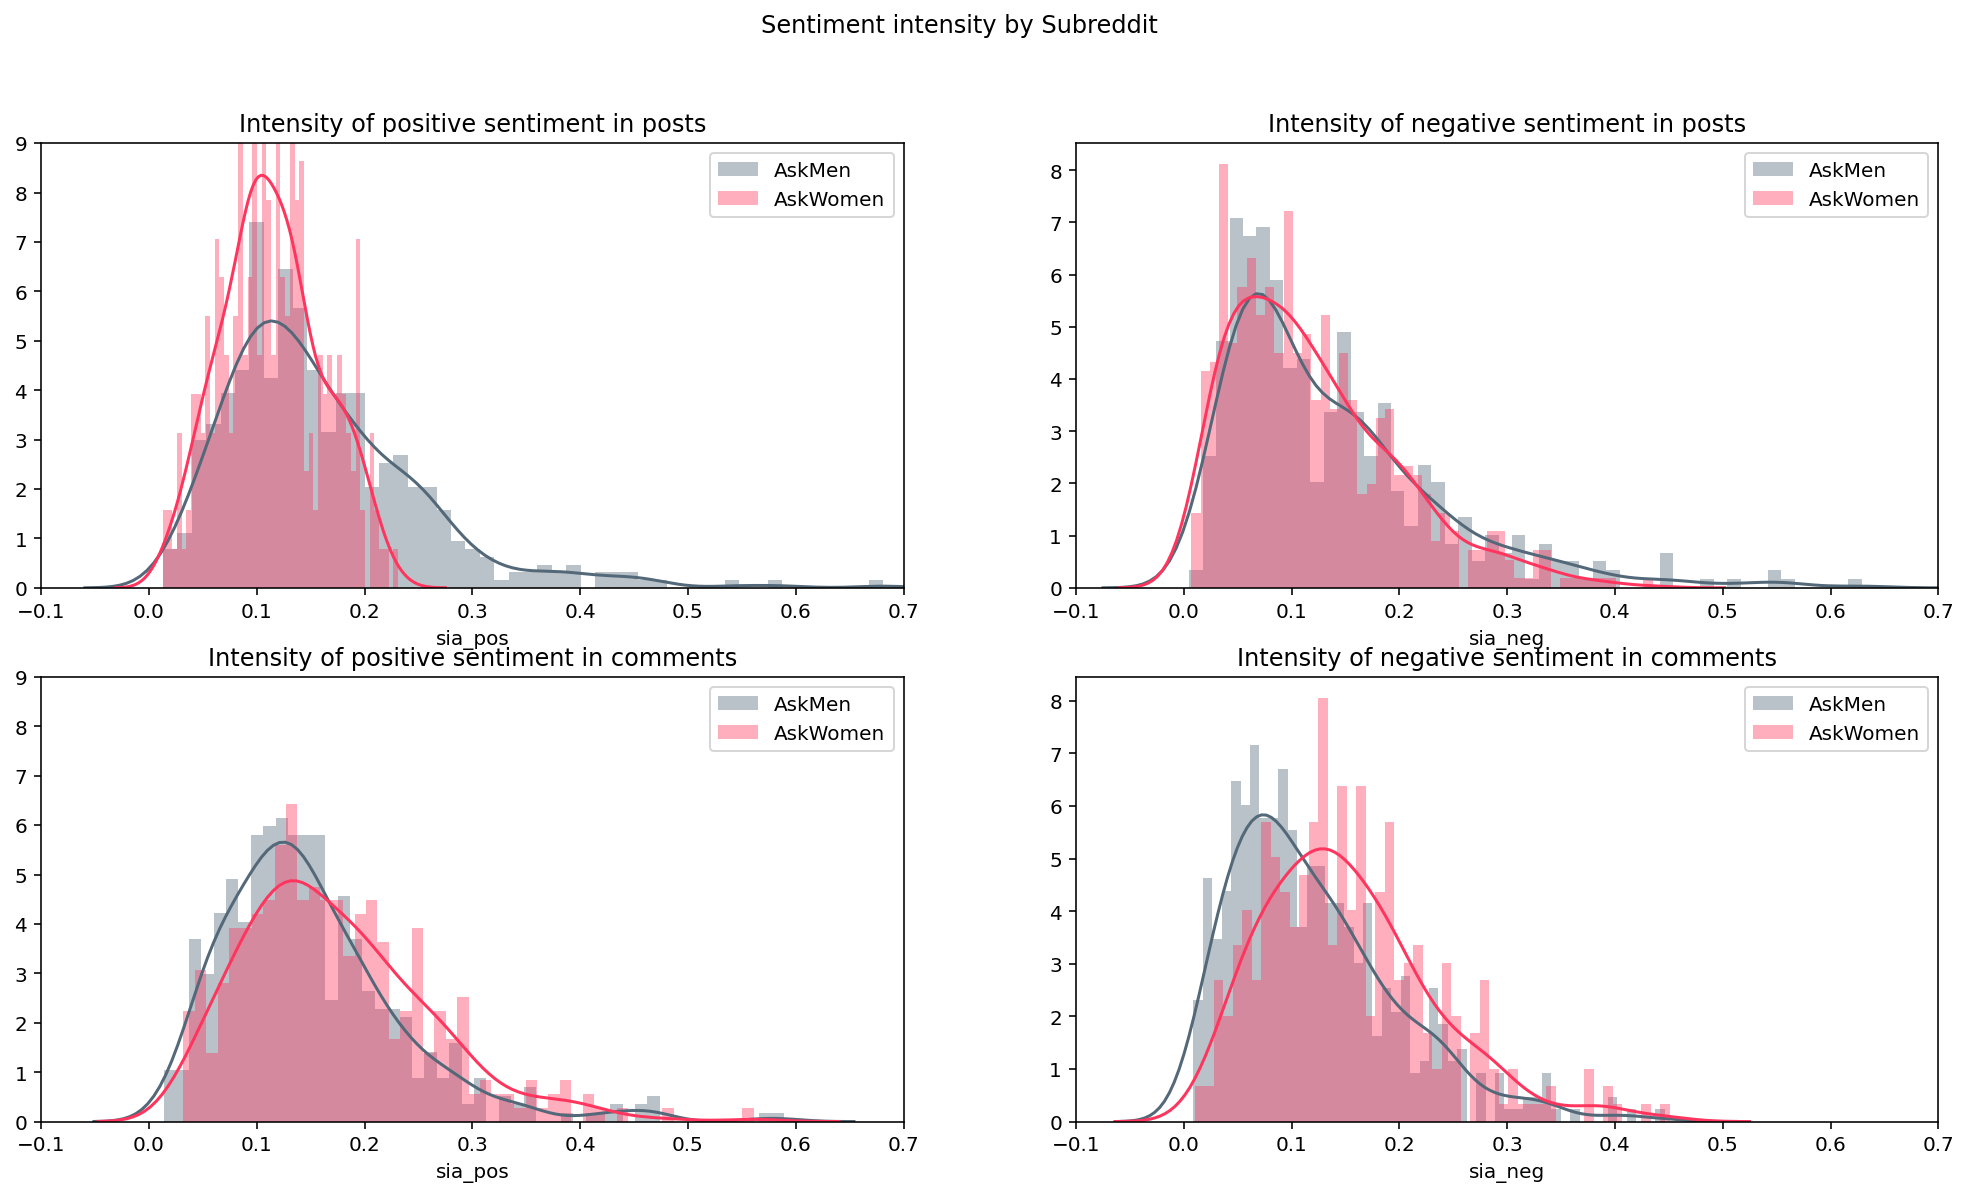

In [291]:
plt.figure(figsize = (17,9))

plt.suptitle('Sentiment intensity by Subreddit')
plt.subplot(2,2,1)
plt.title('Intensity of positive sentiment in posts')
sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AM_comments_df['sia_neg']!=0)]['sia_pos'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AW_comments_df['sia_neg']!=0)]['sia_pos'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.ylim(0,9)
plt.subplot(2,2,2)
plt.title('Intensity of negative sentiment in posts')
sns.distplot(AM_comments_df[(AM_comments_df['sia_pos']!=0) & (AM_comments_df['sia_neg']!=0)]['sia_neg'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AW_comments_df[(AW_comments_df['sia_pos']!=0) & (AW_comments_df['sia_neg']!=0)]['sia_neg'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.subplot(2,2,3)
plt.title('Intensity of positive sentiment in comments')
sns.distplot(AM_posts_df[(AM_posts_df['sia_pos']!=0) & (AM_posts_df['sia_neg']!=0)]['sia_pos'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AW_posts_df[(AW_posts_df['sia_pos']!=0) & (AW_posts_df['sia_neg']!=0)]['sia_pos'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7)
plt.ylim(0,9)
plt.subplot(2,2,4)
plt.title('Intensity of negative sentiment in comments')
sns.distplot(AM_posts_df[(AM_posts_df['sia_pos']!=0) & (AM_posts_df['sia_neg']!=0)]['sia_neg'], color = '#536878', bins = 50, norm_hist=True, label= 'AskMen')
sns.distplot(AW_posts_df[(AW_posts_df['sia_pos']!=0) & (AW_posts_df['sia_neg']!=0)]['sia_neg'], color = '#ff355e', bins = 50, norm_hist=True, label= 'AskWomen')
plt.legend()
plt.xlim(-.1,0.7);

plt.savefig('./visualizations/sent_intensity.png')

#### 3.3.2 Sentiment Analysis using HuggingFace's Sentiment Analysis transformer

In [593]:
#warnings.filterwarnings("ignore", module = 'pipeline')
senti = pipeline('sentiment-analysis')

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['pre_classifier', 'classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-b

In [32]:
AW_posts_df['senti_pn'] = AW_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AW_posts_df['senti_score'] = AW_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [33]:
AM_posts_df['senti_pn'] = AM_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AM_posts_df['senti_score'] = AM_posts_df['title_selftext'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [34]:
AW_comments_df['senti_pn'] = AW_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AW_comments_df['senti_score'] = AW_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [35]:
AM_comments_df['senti_pn'] = AM_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['label'])
AM_comments_df['senti_score'] = AM_comments_df['body'].apply(lambda x: senti(str(x)[:512])[0]['score'])

In [598]:
print(f"{round(len(AW_posts_df[AW_posts_df['senti_pn'] == 'POSITIVE'])/len(AW_posts_df),4)*100}% of posts on AskWomen are categorized as positive.")
print(f"{round(len(AM_posts_df[AM_posts_df['senti_pn'] == 'POSITIVE'])/len(AM_posts_df),4)*100}% of posts on AskMen are categorized as positive.")
print(f"{round(len(AW_posts_df[AW_posts_df['senti_pn'] == 'NEGATIVE'])/len(AW_posts_df),4)*100}% of comments on AskWomen are categorized as negative.")
print(f"{round(len(AM_posts_df[AM_posts_df['senti_pn'] == 'NEGATIVE'])/len(AM_posts_df),4)*100}% of comments on AskMen are categorized as negative.")

21.83% of posts on AskWomen are categorized as positive.
21.93% of posts on AskMen are categorized as positive.
78.17% of comments on AskWomen are categorized as negative.
78.07% of comments on AskMen are categorized as negative.


In [37]:
AM_posts_df['senti_score'].fillna(0, inplace = True)
AM_comments_df['senti_score'].fillna(0, inplace = True)
AW_posts_df['senti_score'].fillna(0, inplace = True)
AW_comments_df['senti_score'].fillna(0, inplace = True)

In [38]:
AM_posts_df['senti_pn'].fillna('NEUTRAL', inplace = True)
AM_comments_df['senti_pn'].fillna('NEUTRAL', inplace = True)
AW_posts_df['senti_pn'].fillna('NEUTRAL', inplace = True)
AW_comments_df['senti_pn'].fillna('NEUTRAL', inplace = True)

In [39]:
AW_posts_df['senti_pn_bin'] = AW_posts_df['senti_pn'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1})
AW_comments_df['senti_pn_bin'] = AW_comments_df['senti_pn'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1})
AM_posts_df['senti_pn_bin'] = AM_posts_df['senti_pn'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1})
AM_comments_df['senti_pn_bin'] = AM_comments_df['senti_pn'].map({'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1})

In [40]:
AM_posts_df['senti_score'] = AM_posts_df['senti_pn_bin']*AM_posts_df['senti_score']
AM_comments_df['senti_score']= AM_comments_df['senti_pn_bin']*AM_comments_df['senti_score']
AW_posts_df['senti_score'] = AW_posts_df['senti_pn_bin']*AW_posts_df['senti_score']
AW_comments_df['senti_score'] = AW_comments_df['senti_pn_bin']*AW_comments_df['senti_score']

In [41]:
AM_posts_df.tail().iloc[:,-5:]

senti_pn  senti_score  sia_neg  sia_pos  senti_pn_bin
1795  POSITIVE     0.999653    0.000    0.312             1
1796  NEGATIVE    -0.939318    0.000    0.000            -1
1797  NEGATIVE    -0.982188    0.102    0.198            -1
1798  NEGATIVE    -0.998752    0.000    0.000            -1
1799  NEGATIVE    -0.997733    0.025    0.106            -1

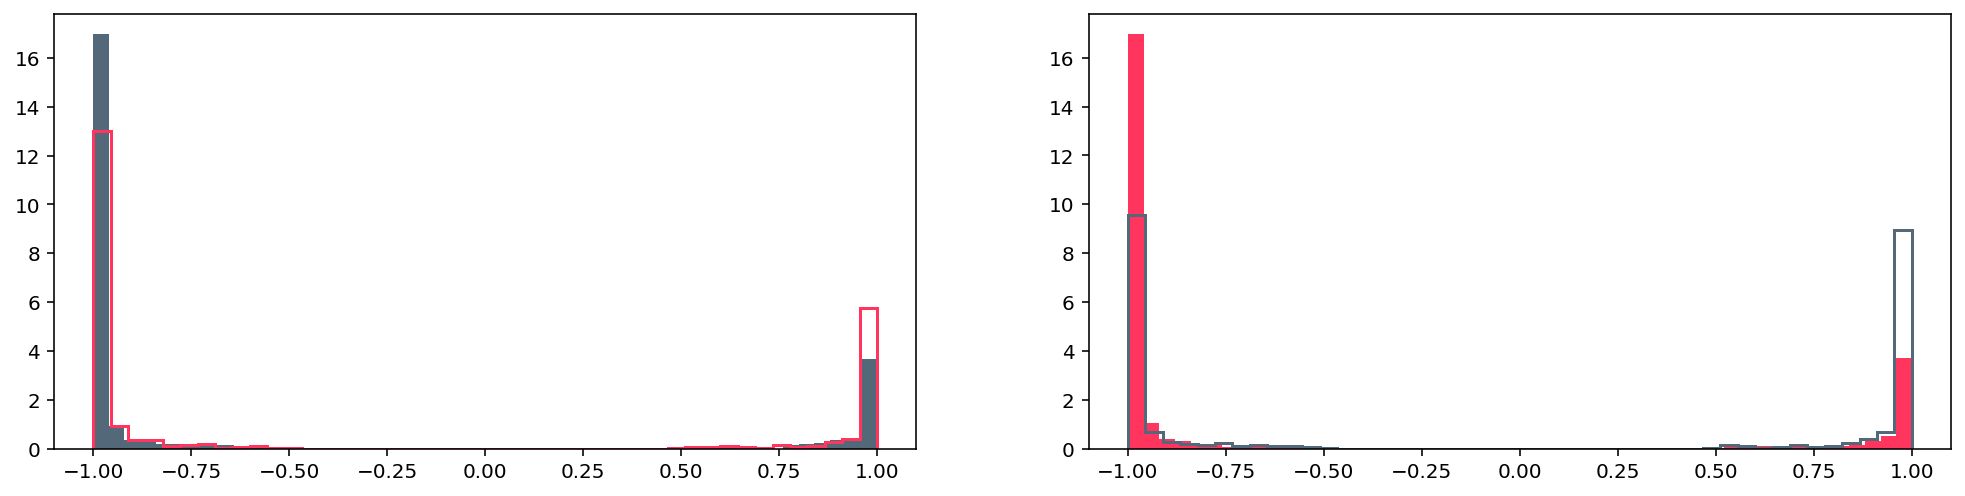

In [290]:
plt.figure(figsize = (17,4))
plt.subplot(1,2,1)
plt.hist(AM_posts_df['senti_score'], density = True, bins = 50, color = '#536878')
plt.hist(AM_comments_df['senti_score'], density = True, bins = 45, color = '#ff355e', histtype= 'step', lw = 1.5)
plt.subplot(1,2,2)
plt.hist(AW_posts_df['senti_score'], density = True, bins = 50, color = '#ff355e')
plt.hist(AW_comments_df['senti_score'], density = True, bins = 45, color = '#536878', histtype= 'step', lw = 1.5);

In [42]:
AW_comments_df.to_csv('aw_com.csv')
AW_posts_df.to_csv('aw_pos.csv')
AM_comments_df.to_csv('am_com.csv')
AM_posts_df.to_csv('am_pos.csv')

**EXPLORATORY ANALYSIS**

In [75]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
AM_tokens = word_tokenize(AM_posts_corpus.lower()+AM_comments_corpus.lower())
AM_stem_tokens = [stemmer.stem(token) for token in AM_tokens]
AM_stem_tokens_no_stops = [token for token in AM_stem_tokens if not token in stops]

In [74]:
AW_tokens = word_tokenize(AW_posts_corpus.lower()+AW_comments_corpus.lower())
AW_stem_tokens = [stemmer.stem(token) for token in AW_tokens]
AW_stem_tokens_no_stops = [token for token in AW_stem_tokens if not token in stops]

In [69]:
'“' in AW_stem_tokens_no_stops

True

In [72]:
stops.extend('“')

In [73]:
'“' in stops

True

In [294]:
# AM_most_common_words = set([word for word, ct in FreqDist(AM_stem_tokens_no_stops).most_common(100)])
# AW_most_common_words = set([word for word, ct in FreqDist(AW_stem_tokens_no_stops).most_common(100)])

# AW_and_AM = set.intersection(AW_most_common_words, AM_most_common_words)

AM_most_common_words = set([word for word, ct in FreqDist(AM_stem_tokens_no_stops).most_common(50)])
AW_most_common_words = set([word for word, ct in FreqDist(AW_stem_tokens_no_stops).most_common(50)])

AW_and_AM = set.union(AW_most_common_words, AM_most_common_words)

In [300]:
common_words = pd.DataFrame(np.array([list(AW_and_AM), [-FreqDist(AM_stem_tokens_no_stops)[word] for word in AW_and_AM],
                             [FreqDist(AW_stem_tokens_no_stops)[word] for word in AW_and_AM]]).T, 
                             columns = ['word', 'AM', 'AW'])

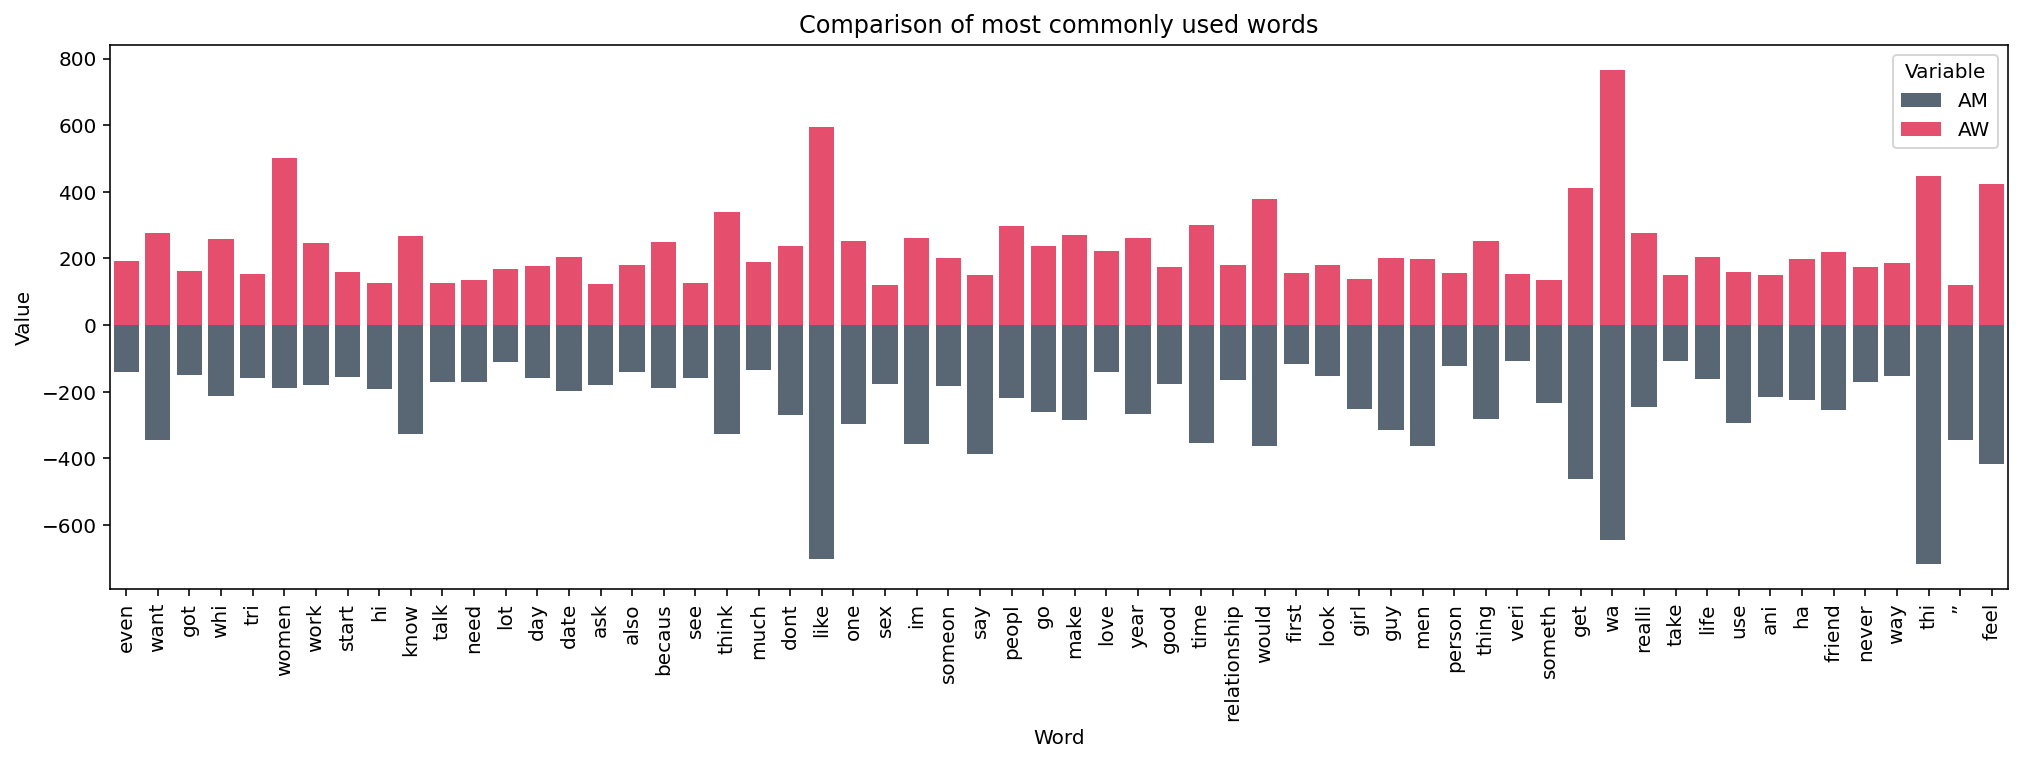

In [301]:
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = common_words.melt(id_vars='word').rename(columns=str.title)
sns.barplot(x='Word', y='Value', hue='Variable', data=tidy, ax = ax1, dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used words')
plt.xticks(rotation = 90);
plt.savefig('./visualizations/common_words.png')

In [169]:
AM_most_common.difference(AW_and_AM)

{'actual',
 'anyth',
 'attract',
 'better',
 'call',
 'come',
 'everi',
 'give',
 'happen',
 'ive',
 'keep',
 'kid',
 'mean',
 'old',
 'reason',
 'right',
 'said',
 'sinc',
 'son',
 'us',
 'well',
 'woman',
 'wrong'}

In [170]:
AW_most_common.difference(AW_and_AM)

{'action',
 'advic',
 'amp',
 'askwomen',
 'care',
 'click',
 'comment',
 'content',
 'els',
 'experi',
 'famili',
 'includ',
 'link',
 'made',
 'messag',
 'moder',
 'mom',
 'pleas',
 'post',
 'read',
 'respons',
 'rule',
 'submiss'}

In [76]:
AW_bigrams = list(ngrams(AW_stem_tokens_no_stops,2))
FreqDist(AW_bigrams)

FreqDist({('feel', 'like'): 85, ('women', 'reddit'): 64, ('thi', 'year'): 38, ('make', 'feel'): 38, ('year', 'old'): 27, ('whi', 'women'): 26, ('everi', 'day'): 25, ('dont', 'know'): 24, ('first', 'time'): 23, ('mental', 'health'): 23, ...})

In [77]:
AM_bigrams = list(ngrams(AM_stem_tokens_no_stops,2))
FreqDist(AM_bigrams)

FreqDist({('feel', 'like'): 96, ('men', 'reddit'): 67, ('year', 'old'): 53, ('dont', 'know'): 46, ('like', 'thi'): 35, ('wan', 'na'): 32, ('gon', 'na'): 32, ('thi', 'year'): 30, ('dont', 'want'): 28, ('make', 'feel'): 27, ...})

In [302]:
# AM_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,2)).most_common(100)])
# AW_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,2)).most_common(100)])

# AW_and_AM_bi = set.intersection(AW_most_common_bi, AM_most_common_bi)

AM_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,2)).most_common(40)])
AW_most_common_bi = set([bi for bi, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,2)).most_common(40)])

AW_and_AM_bi = set.union(AW_most_common_bi, AM_most_common_bi)

In [303]:
common_bis = pd.DataFrame(np.array([list(AW_and_AM_bi), 
                            [-FreqDist(ngrams(AM_stem_tokens_no_stops,2))[bi] for bi in AW_and_AM_bi],
                            [FreqDist(ngrams(AW_stem_tokens_no_stops,2))[bi] for bi in AW_and_AM_bi]]).T, 
                             columns = ['bigram', 'AM', 'AW'])

<ipython-input-303-03db1970efd8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_bis = pd.DataFrame(np.array([list(AW_and_AM_bi),


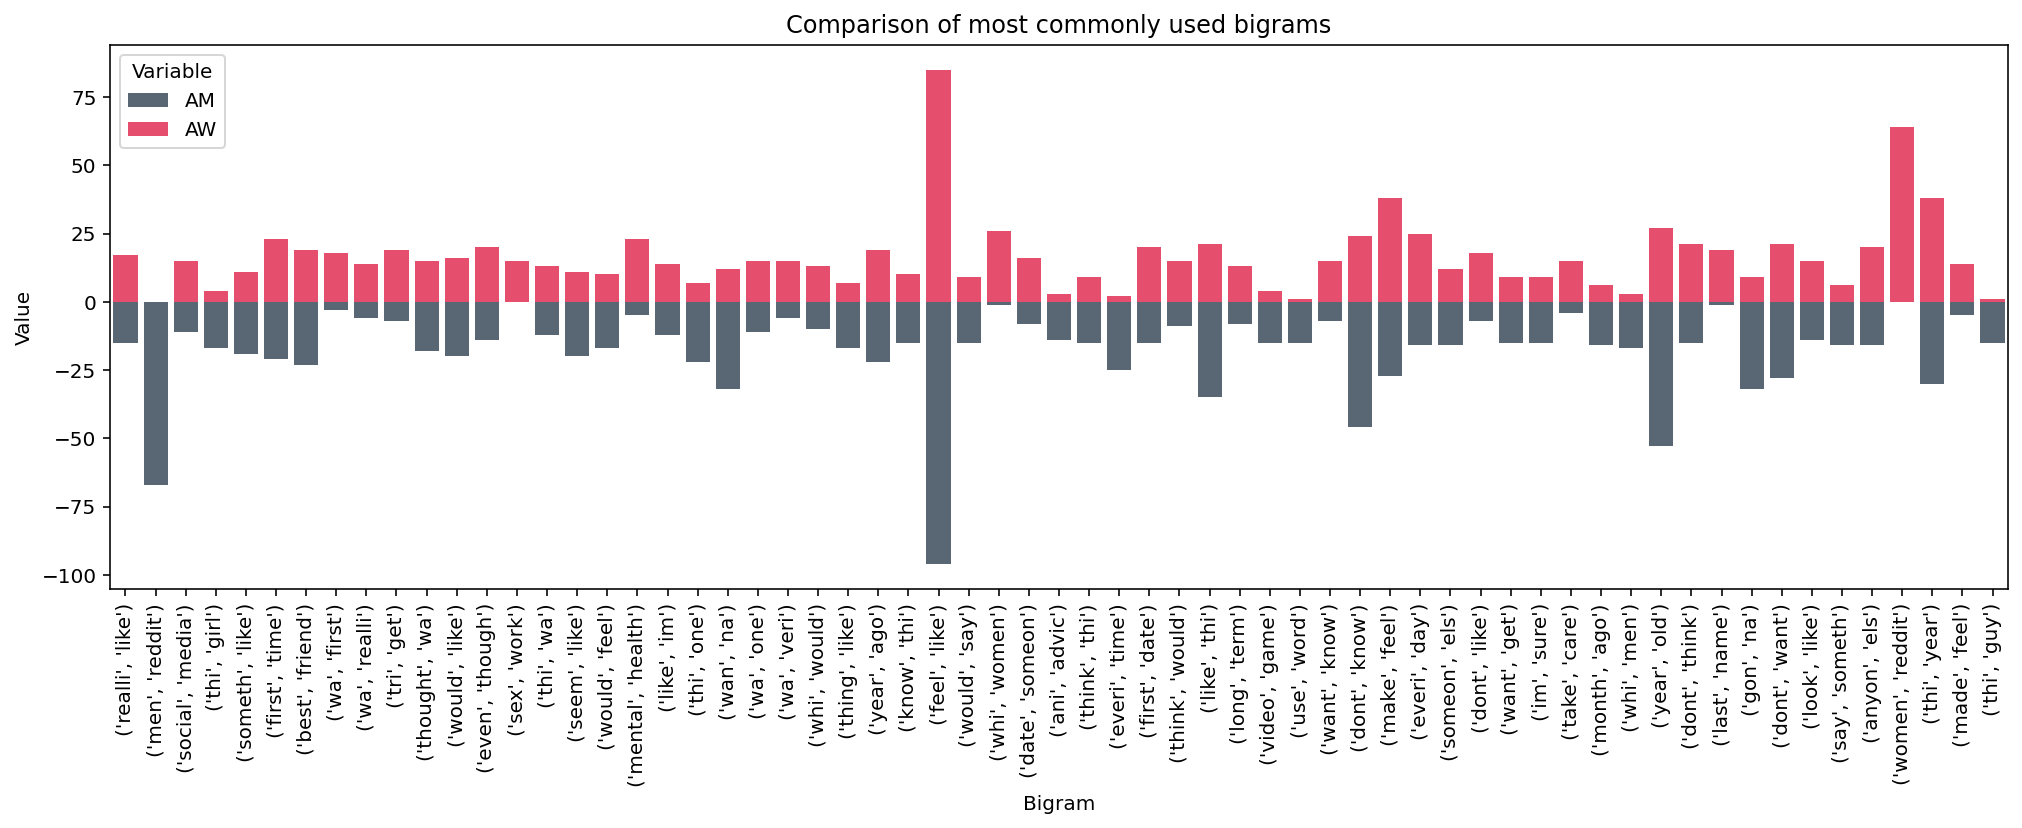

In [304]:
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = common_bis.melt(id_vars='bigram').rename(columns=str.title)
sns.barplot(x='Bigram', y='Value', hue='Variable', data=tidy, ax = ax1, dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used bigrams')
plt.xticks(rotation = 90);
plt.savefig('./visualizations/common_bigrams.png')

In [78]:
AW_trigrams = list(ngrams(AW_stem_tokens_no_stops,3)) #AW_stem_tokens_no_stops
FreqDist(AW_trigrams)

FreqDist({('feel', 'like', 'im'): 7, ('got', 'back', 'togeth'): 7, ('long', 'term', 'relationship'): 6, ('legal', 'sex', 'work'): 6, ('would', 'date', 'man'): 5, ('delet', 'social', 'media'): 5, ('feel', 'thi', 'way'): 5, ('make', 'feel', 'bad'): 5, ('birth', 'control', 'pill'): 4, ('doe', 'anyon', 'els'): 4, ...})

In [79]:
AM_trigrams = list(ngrams(AM_stem_tokens_no_stops,3))
FreqDist(AM_trigrams)

FreqDist({('play', 'video', 'game'): 10, ('amp', '#', 'xb'): 9, ('year', 'old', 'dad'): 7, ('im', 'year', 'old'): 6, ('men', 'reddit', 'doe'): 6, ('advic', 'would', 'give'): 6, ('feel', 'like', 'im'): 6, ('remain', 'friend', 'ex'): 6, ('ai', 'ai', 'dungeon'): 6, ('ai', 'dungeon', 'sexi'): 6, ...})

In [305]:
# AM_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,3)).most_common(100)])
# AW_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,3)).most_common(100)])

# AW_and_AM_tri = set.intersection(AW_most_common_tri, AM_most_common_tri)

AM_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AM_stem_tokens_no_stops,3)).most_common(40)])
AW_most_common_tri = set([tri for tri, ct in FreqDist(ngrams(AW_stem_tokens_no_stops,3)).most_common(40)])

AW_and_AM_tri = set.union(AW_most_common_tri, AM_most_common_tri)

In [306]:
common_tris = pd.DataFrame(np.array([list(AW_and_AM_tri), 
                                     [-FreqDist(ngrams(AM_stem_tokens_no_stops,3))[tri] for tri in AW_and_AM_tri],
                                      [FreqDist(ngrams(AW_stem_tokens_no_stops,3))[tri] for tri in AW_and_AM_tri]]).T, 
                                     columns = ['trigram', 'AM', 'AW'])

<ipython-input-306-52334ec0766e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  common_tris = pd.DataFrame(np.array([list(AW_and_AM_tri),


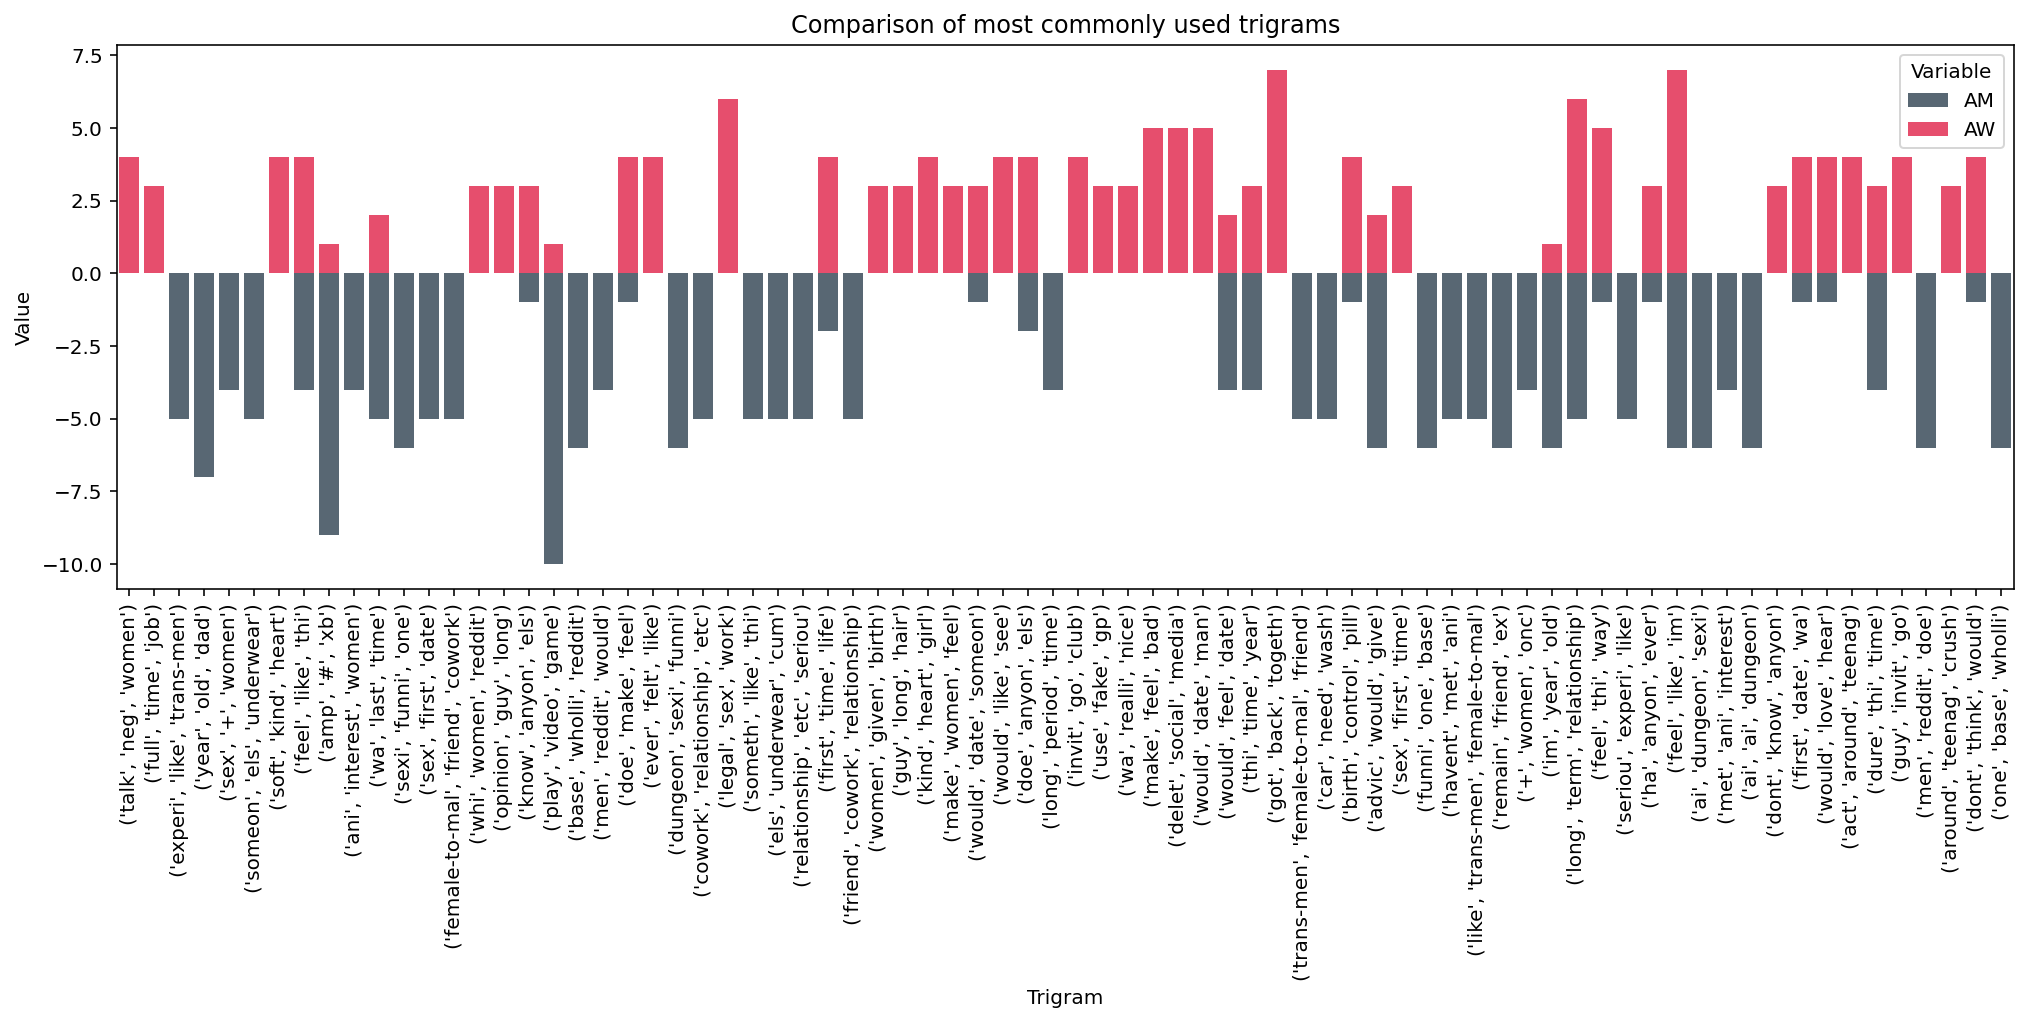

In [307]:
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = common_tris.melt(id_vars='trigram').rename(columns=str.title)
sns.barplot(x='Trigram', y='Value', hue='Variable', data=tidy, ax = ax1, dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used trigrams')
plt.xticks(rotation = 90);
plt.savefig('./visualizations/common_trigrams.png')

In [48]:
AW_vocabulary = sorted(list(set((AW_posts_corpus+AW_comments_corpus).lower().split())))
AM_vocabulary = sorted(list(set((AM_posts_corpus+AM_comments_corpus).lower().split())))

print("=========AskMen=========")
print(len(AM_vocabulary))
print("\n========AskWomen========")
print(len(AW_vocabulary))

=========AskMen=========
14904

========AskWomen========
14490


In [433]:
import emoji

def extract_emojis(s):
  return [c for c in s if c in emoji.UNICODE_EMOJI]

In [447]:
AW_emojis = set(extract_emojis(AW_posts_corpus+AW_comments_corpus))
AM_emojis = set(extract_emojis(AM_posts_corpus+AM_comments_corpus))

In [14]:
print(f"AskWomen posts and comments feature {len(AW_emojis)} emojis: {AW_emojis}")

AskWomen posts and comments feature 49 emojis: {'🤥', '🥺', '🤣', '😯', '🥰', '💕', '😅', '😳', '😊', '👀', '🤷', '🏻', '👇', '🎅', '🙏', '💥', '🙂', '🏾', '🙄', '❤', '💍', '✋', '🌚', '🤦', '🎁', '💚', '🥴', '😋', '🎄', '❓', '♀', '☺', '♥', '🙃', '🤔', '😔', '🤢', '😂', '😭', '👰', '😍', '😱', '💖', '🤡', '😆', '💁', '🏼', '🤭', '✨'}


In [15]:
print(f"AskMen posts and comments feature {len(AM_emojis)} emojis: {AM_emojis}")

AskMen posts and comments feature 165 emojis: {'😝', '💩', '🧐', '👶', '🉐', '🌄', '💕', '🤷', '🙌', '🏻', '🌈', '🤚', '🐣', '🚴', '🙈', '✅', '🌙', '🎄', '❓', '🤔', '🐾', '💨', '😭', '🌎', '🤞', '🐝', '🍻', '😱', '👉', '👈', '🇦', '😃', '🗣', '🔗', '🍆', '😈', '👬', '👧', '👭', '✔', '🚬', '⚰', '🏃', '😠', '👅', '⏰', '💼', '👊', '😌', '📅', '🔚', '🇵', '🏾', '💬', '😀', '😏', '☀', '📷', '❔', '👫', '🚶', '💅', '♀', '👌', '🚡', '😔', '👣', '👋', '💹', '🤫', '⬆', '🎼', '👪', '🏘', '💓', '🏽', '🙇', '🍓', '📖', '😤', '💢', '🥶', '🌾', '🤣', '💯', '🙀', '😒', '💪', '🧔', '👁', '👀', '👴', '🏫', '👇', '🙏', '💥', '🔫', '❎', '🚨', '🙄', '🍂', '✋', '🌞', '😜', '😐', '🏿', '🏳', '😩', '👩', '👵', '🍑', '💰', '👱', '😮', '😓', '😆', '🏼', '🌬', '🙅', '🔥', '🎣', '✨', '👥', '💔', '🚫', '🕛', '🎤', '😬', '💦', '❄', '🌪', '🤽', '🏊', '😯', '👍', '☝', '😢', '👦', '📦', '🔔', '🔁', '👻', '🌹', '💀', '🚯', '❤', '✊', '🐰', '❌', '📆', '👨', '📝', '🧠', '🚑', '😂', '📒', '♂', '🔍', '📼', '🌟', '🕺', '🤡', '🏄', '😎', '🤠'}


In [158]:
emoji.UNICODE_EMOJI['🚫']

':prohibited:'

In [190]:
AM_emojis_freq = {emo: (AM_posts_corpus+AM_comments_corpus).count(emo) for emo in AM_emojis}
AW_emojis_freq = {emo: (AW_posts_corpus+AW_comments_corpus).count(emo) for emo in AW_emojis}
emos = list(set([emo for emo in AM_emojis_freq.keys() if AM_emojis_freq[emo]>= 3]+[emo for emo in AW_emojis_freq.keys() if AW_emojis_freq[emo]>= 3]))

In [319]:
emos_chart = pd.DataFrame(np.array([[emoji.UNICODE_EMOJI[emo] for emo in emos], 
                                    [-AM_emojis_freq.setdefault(emo,0) for emo in emos],
                                     [AW_emojis_freq.setdefault(emo,0) for emo in emos]]).T, 
                                     columns = ['descr', 'AM', 'AW'])

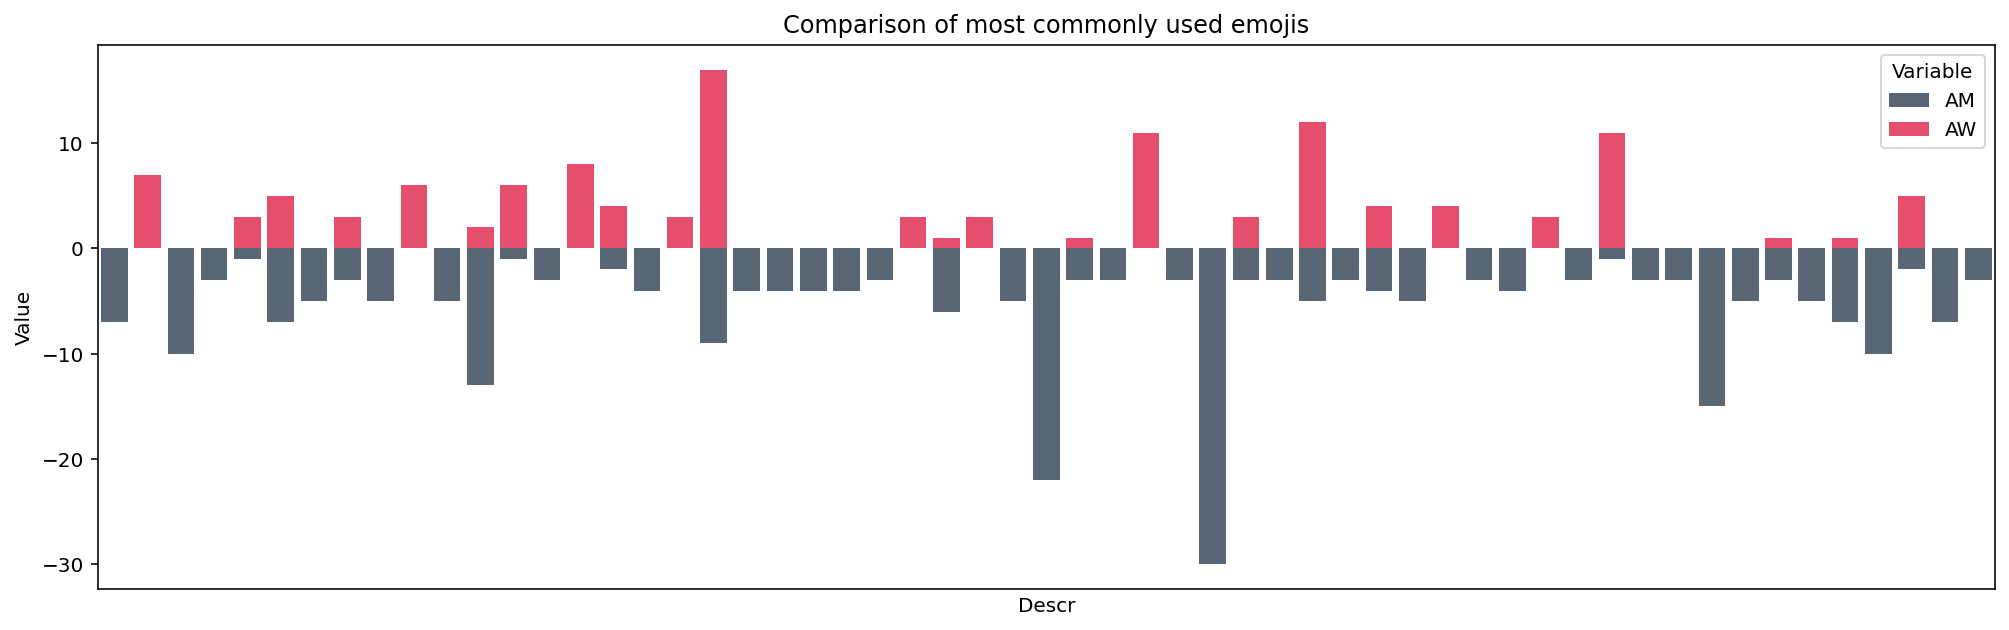

In [201]:

from matplotlib.font_manager import FontProperties
prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')
fig, ax1 = plt.subplots(figsize=(17,5))
tidy = emos_chart.melt(id_vars='descr').rename(columns=str.title)
sns.barplot(x='Descr', y='Value', hue='Variable', data=tidy,  dodge = False, palette = ['#536878','#ff355e'])
plt.title('Comparison of most commonly used emojis')
plt.xticks([]);
plt.savefig('./visualizations/common_emojis.png')

In [196]:
" ".join(emos)

'🚫 🥺 💯 😎 🏾 🏼 👥 🤔 👍 😅 🚶 🏻 ♀ 👬 😍 😭 👌 ☺ 😂 👊 👦 💪 😌 🐰 🥰 👀 😳 💨 👨 ✋ 🔫 ♥ 🙌 👁 🙄 🙀 🤣 🗣 🙏 😩 🤭 👉 🍆 🌚 🏫 ❤ 👈 🔁 💦 ❌ 😔 😈 💥 ♂ 🤷 😀 🙅'

In [321]:
AW_posts_df['emojis'] = AW_posts_df['title_selftext'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))
AM_posts_df['emojis'] = AM_posts_df['title_selftext'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))
AW_comments_df['emojis'] = AW_comments_df['body'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))
AM_comments_df['emojis'] = AM_comments_df['body'].apply(lambda x: sum([1 for c in str(x) if c in emoji.UNICODE_EMOJI]))

In [454]:
content = "This sign means prohibited: 🚫"
modified = re.sub(emoji.get_emoji_regexp(), "", content)
modified

'This sign means prohibited: '

In [261]:
AW_posts_df['emojis'].describe()

count    2000.000000
mean        0.019500
std         0.249301
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: emojis, dtype: float64

In [262]:
AM_posts_df['emojis'].describe()

count    1800.000000
mean        0.013333
std         0.255762
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: emojis, dtype: float64

**CAN THSIS BE SOMETHING STILL?**

In [272]:
text_subreddit = pd.concat([AW_posts_df[['title_selftext', 'subreddit']], AW_comments_df[['body', 'subreddit']], 
               AM_posts_df[['title_selftext', 'subreddit']], AM_comments_df[['body', 'subreddit']]], axis = 0)

text_subreddit['title_selftext'] = text_subreddit['title_selftext'].fillna("")
text_subreddit['body'] = text_subreddit['body'].fillna("")
text_subreddit['text'] = text_subreddit['title_selftext']+text_subreddit['body']

import spacy
import scattertext as st

nlp = spacy.load('en_core_web_sm')
corpus = st.CorpusFromPandas(text_subreddit,
                              category_col='subreddit',
                              text_col='text',
                              nlp=nlp).build()

#### Exporting enhanced data to csv files for retrieval in subsequent parts

In [536]:
AW_comments_df.to_csv('aw_com.csv')
AW_posts_df.to_csv('aw_pos.csv')
AM_comments_df.to_csv('am_com.csv')
AM_posts_df.to_csv('am_pos.csv')

# PART 4: Classification

**PYTHON IMPORTS!!!**

#### Retrieving data harvested in step 1, clened in step 2, and enhanced in step 3 from csv files to dataframes

In [192]:
AW_comments_df = pd.read_csv('aw_com.csv')
AW_posts_df = pd.read_csv('aw_pos.csv')
AM_comments_df = pd.read_csv('am_com.csv')
AM_posts_df = pd.read_csv('am_pos.csv')

## 4.1 Baseline model

In [720]:
def baseline_model(indep,dep): # time permitting, I could deploy this as a class?
    if dep.mean()> 0.5:
        prediction = np.ones_like(dep)
    else:
        prediction = np.zeros_like(dep)
    return prediction

In [725]:
print(f"The baseline model accuracy is {round(accuracy_score(y, baseline_model(X,y)), 4)}.")

The baseline model accuracy is 0.5011.


## 4.2 Classification based only on content (posts and comments)

In [319]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), AM_posts_df['title_selftext'].dropna(), 
               AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, random_state = 1)

In [144]:
cvec = CountVectorizer(stop_words='english', lowercase = True, ngram_range=(1,3))#max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [425]:
tvec = TfidfVectorizer(stop_words='english', lowercase = True, ngram_range=(1,3), use_idf = True, token_pattern=r'[^\s]+')#max_features=10_000)
train_X_vec = tvec.fit_transform(train_X)
test_X_vec = tvec.transform(test_X)

In [429]:
#tvec.get_feature_names()

In [427]:
logreg = LogisticRegression()
logreg.fit(train_X_vec, train_y)
logreg.score(test_X_vec, test_y)

0.6793981481481481

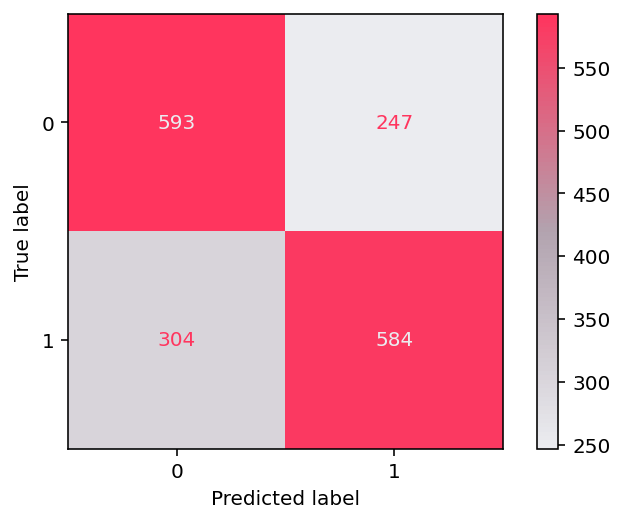

In [322]:
plot_confusion_matrix(logreg, test_X_vec, test_y, cmap= pnkgry);

In [430]:
mnb = MultinomialNB()

mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

0.9909318927262203

In [431]:
mnb.score(test_X_vec, test_y)

0.6840277777777778

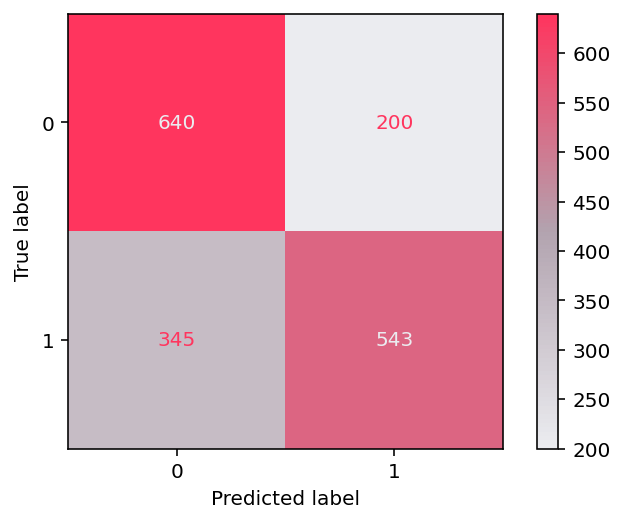

In [325]:
plot_confusion_matrix(mnb, test_X_vec, test_y, cmap= pnkgry);

In [326]:
X_vec = cvec.transform(X)

params = {'alpha': np.linspace(0,1,10)}
mnb_gs = GridSearchCV(mnb, params, n_jobs = 5, verbose = 1, cv = 5)

mnb_gs.fit(X_vec, y)
print(f"Best CV score of {round(mnb_gs.best_score_,4)} achieved with alpha = {round(mnb_gs.best_params_['alpha'],4)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Best CV score of 0.6704 achieved with alpha = 0.6667


[Parallel(n_jobs=5)]: Done  41 out of  50 | elapsed:    2.0s remaining:    0.4s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    2.1s finished


### Classifying using word vector and sentiment scores

In [197]:
AW_posts_df.dropna(subset = ['title_selftext'], inplace=True)
AW_comments_df.dropna(subset = ['body'],inplace=True)
AM_posts_df.dropna(subset = ['title_selftext'],inplace=True)
AM_comments_df.dropna(subset = ['body'],inplace=True)

In [205]:
X_cont = pd.concat([AW_posts_df['title_selftext'], AW_comments_df['body'], 
                    AM_posts_df['title_selftext'], AM_comments_df['body']], axis = 0)

X_sent = pd.concat([AW_posts_df[['sia_neg', 'sia_pos', 'senti_score']], AW_comments_df[['sia_neg', 'sia_pos', 'senti_score']],
                  AM_posts_df[['sia_neg', 'sia_pos', 'senti_score']], AM_comments_df[['sia_neg', 'sia_pos', 'senti_score']]], axis = 0)

X = pd.concat([X_cont, X_sent], axis = 1)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext']),
                    np.zeros_like(AW_comments_df['body']),
                    np.ones_like(AM_posts_df['title_selftext']),
                    np.ones_like(AM_comments_df['body'])]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 11)

tvec = TfidfVectorizer()
#tvec.fit(X_train.iloc[:,0])

X_train_vec = pd.merge(pd.DataFrame(tvec.fit_transform(X_train.iloc[:,0]).todense()), X_train.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

X_test_vec = pd.merge(pd.DataFrame(tvec.transform(X_test.iloc[:,0]).todense()), X_test.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

In [198]:
AW_posts_df.shape[0]+AM_posts_df.shape[0]+AM_comments_df.shape[0]+AW_comments_df.shape[0]

6911

In [202]:
X_sent.shape

(6911, 3)

In [206]:
logreg = LogisticRegression(max_iter = 10_000)
logreg.fit(X_train_vec,y_train)
logreg.score(X_train_vec, y_train)

0.7250539956803456

In [207]:
logreg.score(X_test_vec, y_test)

0.5006576063130206

In [211]:
X_vec = pd.concat([X_train_vec, X_test_vec], axis = 0)

y = np.concatenate([y_train, y_test])

In [224]:
y.shape

(6911,)

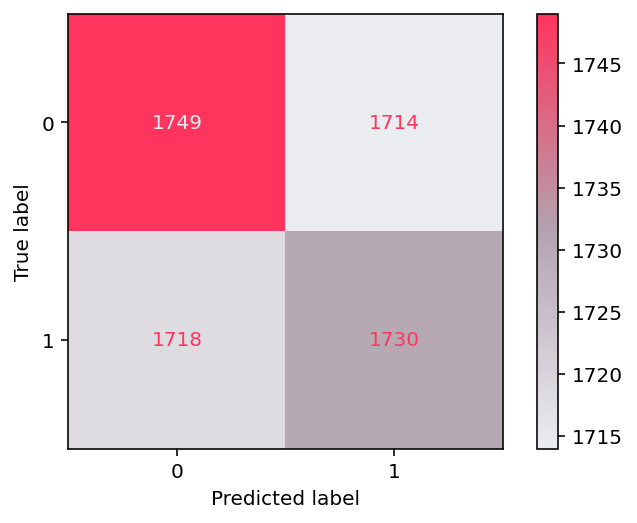

In [230]:
plot_confusion_matrix(logreg, X_vec,y, cmap= pnkgry);

In [234]:
logreg.score(X_vec,y)

0.5034003762118362

In [236]:
cross_val_score(logreg, X_vec, y, cv = 5).mean()

0.6343183142835318

### Classifying using word vector, sentiment scores, emoji count, as well as emojis as discrete features

WITHOUT EMOJIS (only count)

In [242]:
X_cont = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)


X_sent_emo = pd.concat([AW_posts_df[AW_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']], 
                        AW_comments_df[AW_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']],
                        AM_posts_df[AM_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score','emojis']], 
                        AM_comments_df[AM_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']]], axis = 0)

X = pd.concat([X_cont, X_sent_emo], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 11)

tvec = TfidfVectorizer()
X_train_vec = pd.merge(pd.DataFrame(tvec.fit_transform(X_train.iloc[:,0]).todense()), X_train.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

X_test_vec = pd.merge(pd.DataFrame(tvec.transform(X_test.iloc[:,0]).todense()), X_test.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)

In [318]:
X_test_vec.shape

(2409, 9745)

In [243]:
logreg = LogisticRegression(max_iter = 10_000)
logreg.fit(X_train_vec,y_train)
logreg.score(X_train_vec, y_train)

0.7252699784017279

In [244]:
logreg.score(X_test_vec, y_test)

0.501096010521701

In [245]:
X_vec = pd.concat([X_train_vec, X_test_vec], axis = 0)

y = np.concatenate([y_train, y_test])

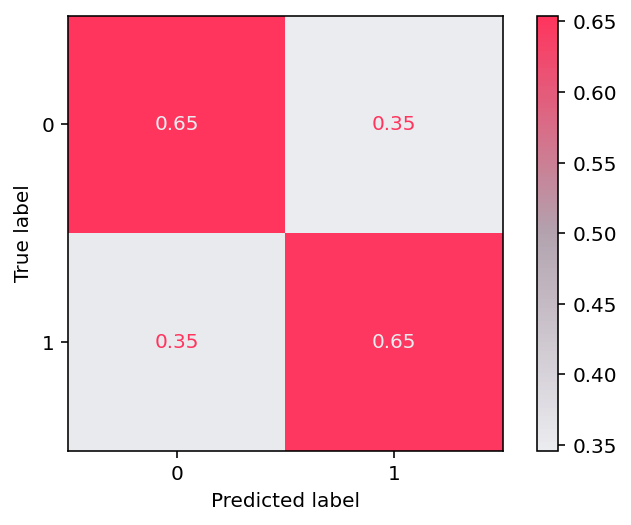

In [248]:
plot_confusion_matrix(logreg, X_vec,y, cmap= pnkgry, normalize='true');

In [249]:
logreg.score(X_vec,y)

0.6512805672116915

**WITH EMOJIS**

In [426]:
'😂' in tvec.get_feature_names() 
# changing from default token_pattern to r'[^\s]+' gets the emojis in but along with it comes a lot of other garbage

True

In [465]:
X_cont = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)


X_sent_emo = pd.concat([AW_posts_df[AW_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']], 
                        AW_comments_df[AW_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']],
                        AM_posts_df[AM_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score','emojis']], 
                        AM_comments_df[AM_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']]], axis = 0)

X = pd.concat([X_cont, X_sent_emo], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 11)

emovec = CountVectorizer(token_pattern=emoji.get_emoji_regexp())
tvec = TfidfVectorizer()
X_train_vec = pd.merge(pd.DataFrame(tvec.fit_transform(X_train.iloc[:,0]).todense()),
                       X_train.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)
X_train_emo_vec = pd.merge(X_train_vec,  pd.DataFrame(emovec.fit_transform(X_train.iloc[:,0]).todense()),
                           how = 'inner', left_index= True, right_index= True)

X_test_vec = pd.merge(pd.DataFrame(tvec.transform(X_test.iloc[:,0]).todense()), X_test.iloc[:,1:], how = 'inner', 
                        left_index= True, right_index= True)
X_test_emo_vec = pd.merge(X_test_vec,  pd.DataFrame(emovec.transform(X_test.iloc[:,0]).todense()),
                           how = 'inner', left_index= True, right_index= True)


In [466]:
logreg = LogisticRegression(max_iter = 10_000)
logreg.fit(X_train_emo_vec,y_train)
logreg.score(X_train_emo_vec, y_train)

0.7278617710583153

In [467]:
logreg.score(X_test_emo_vec, y_test)

0.503288031565103

In [470]:
X_emo_vec = pd.concat([X_train_emo_vec, X_test_emo_vec], axis = 0)
y = np.concatenate([y_train, y_test])

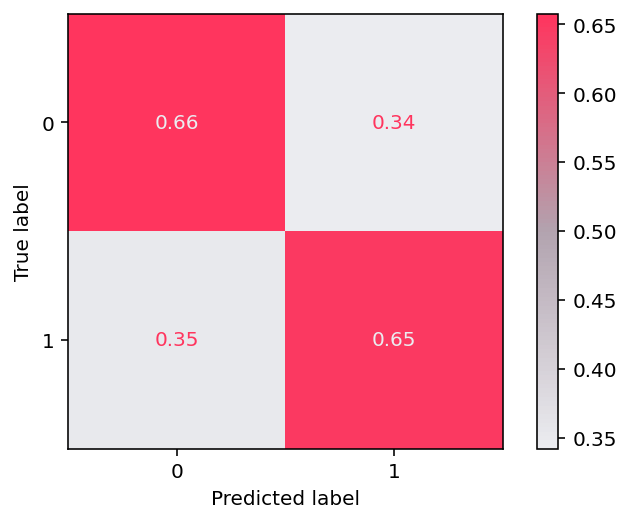

In [471]:
plot_confusion_matrix(logreg, X_emo_vec,y, cmap= pnkgry);

### BAGGING

In [251]:
bag = BaggingClassifier()
bag.fit(X_train_vec, y_train)
bag.score(X_train_vec, y_train)

0.9723542116630669

In [252]:
bag.score(X_test_vec, y_test)

0.5006576063130206

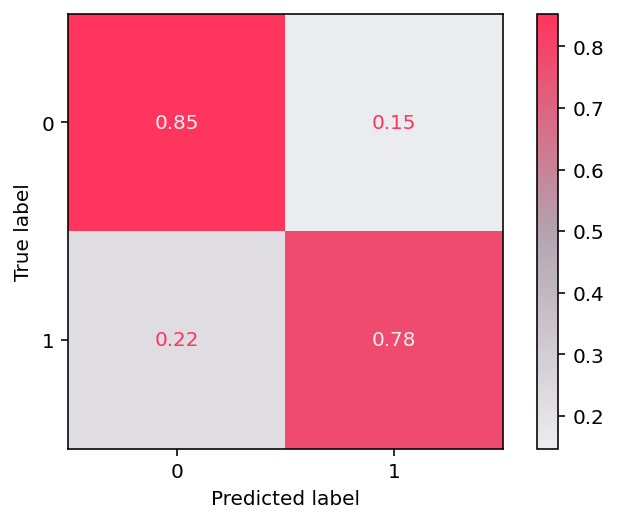

In [253]:
plot_confusion_matrix(bag, X_vec, y, cmap= pnkgry, normalize='true');

### OTHER MODELS

**K-Nearest Neighbors**

In [274]:
X = pd.concat([AW_posts_df['title_selftext'], AW_comments_df['body'], 
                    AM_posts_df['title_selftext'], AM_comments_df['body']], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext']),
                    np.zeros_like(AW_comments_df['body']),
                    np.ones_like(AM_posts_df['title_selftext']),
                    np.ones_like(AM_comments_df['body'])]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.33)

tvec = TfidfVectorizer()
#stan = StandardScaler()
train_X_vec = tvec.fit_transform(train_X)
#train_X_vec_sc = stan.fit_transform(train_X_vec)

test_X_vec = tvec.transform(test_X)
#test_X_vec_sc = stan.transform(test_X_vec)

In [275]:
knn = KNeighborsClassifier()
knn.fit(train_X_vec, train_y)
knn.score(test_X_vec, test_y)

0.6584831214379658

In [276]:
X_vec = pd.concat([pd.DataFrame(train_X_vec.todense()), pd.DataFrame(test_X_vec.todense())], axis = 0)

y = np.concatenate([train_y, test_y])

In [271]:
X_vec.shape

(6911, 9594)

In [272]:
y.shape

(6911,)

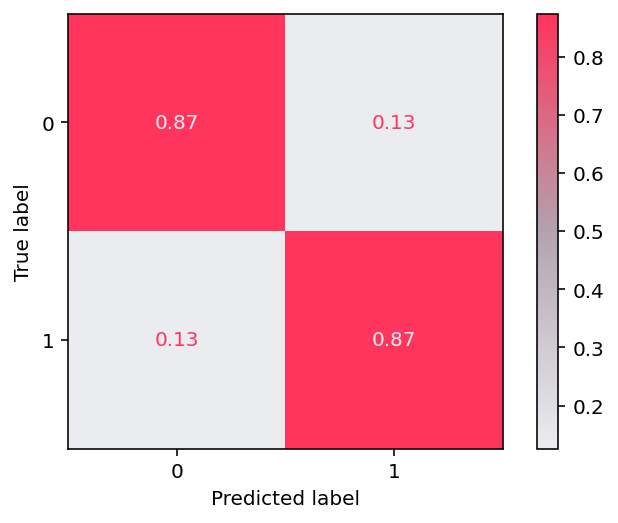

In [278]:
plot_confusion_matrix(knn, X_vec, y, cmap= pnkgry, normalize='true');

In [264]:
for k in range(1,11):
    knn = KNeighborsClassifier(k)
    print(f"k = {k} --> score = {round(cross_val_score(knn, X_vec, y).mean(),4)}")

k = 1 --> score = 0.5031
k = 2 --> score = 0.5031
k = 3 --> score = 0.5017
k = 4 --> score = 0.5001
k = 5 --> score = 0.5051
k = 6 --> score = 0.5096
k = 7 --> score = 0.5105
k = 8 --> score = 0.5099
k = 9 --> score = 0.5017
k = 10 --> score = 0.5064


**Random Forest Classifier**

In [279]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.2)

tvec = TfidfVectorizer()
train_X_vec = tvec.fit_transform(train_X)
test_X_vec = tvec.transform(test_X)

In [280]:
rfc = RandomForestClassifier()
rfc.fit(train_X_vec, train_y)
rfc.score(train_X_vec, train_y)

0.9965629522431259

In [281]:
rfc.score(test_X_vec, test_y)

0.7093275488069414

In [282]:
X_vec = pd.concat([pd.DataFrame(train_X_vec.todense()), pd.DataFrame(test_X_vec.todense())], axis = 0)

y = np.concatenate([train_y, test_y])

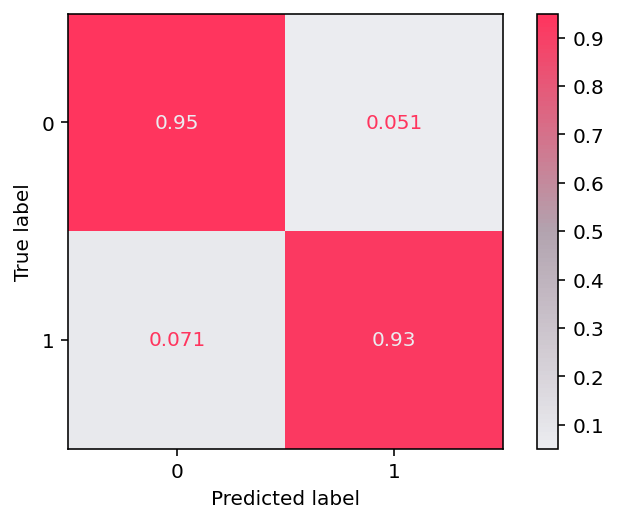

In [283]:
plot_confusion_matrix(rfc, X_vec, y, cmap= pnkgry, normalize='true');

In [363]:
params = {'bootstrap': [True],
 'ccp_alpha': np.linspace(0,1,5),
 'criterion': ['gini'],
 'max_depth': [2,5,10,15],
 'min_samples_leaf': [1,2,3,4,5],
 'n_estimators': [25,50,75,100,125]}

rfc_gs = GridSearchCV(rfc, params, cv = 5, n_jobs = 5, verbose = 1)

rfc_gs.fit(train_X_vec, train_y)
rfc_gs.best_score_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   34.2s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  7.1min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 10.6min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 15.1min
[Parallel(n_jobs=5)]: Done 2500 out of 2500 | elapsed: 15.8min finished


0.6513539576220386

In [365]:
rfc_gs.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'n_estimators': 125}

### cvec / tfidf MNB GridSearch

In [416]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)


y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

In [417]:
cvec_mnb_pipe = Pipeline([('cvec', CountVectorizer()), 
                          ('mnb', MultinomialNB())])

cvec_mnb_params = {'cvec__stop_words': ['english', None],
                    'cvec__ngram_range': [(1,1), (1,2), (2,2), (1,3), (3,3)],
                  'cvec__max_features': [5_000, 10_000, None],
                    'cvec__max_df': [0.7, 0.8, 0.9],
                  'mnb__alpha': np.linspace(0,1,10)}

cvec_mnb_gs = GridSearchCV(cvec_mnb_pipe, cvec_mnb_params, cv = 5, verbose = 1, n_jobs = 5)
cvec_mnb_gs.fit(X,y)
cvec_mnb_gs.best_score_

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   31.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  4.6min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  7.2min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  9.9min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 16.4min
[Parallel(n_jobs=5)]: Done 4500 out of 4500 | elapsed: 18.8min finished


0.655484051219428

In [418]:
cvec_mnb_gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': None,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': 'english',
 'mnb__alpha': 0.3333333333333333}

In [419]:
cvec_mnb_gs_best_params = {'cvec__max_df': 0.7,
                         'cvec__max_features': None,
                         'cvec__ngram_range': (1, 3),
                         'cvec__stop_words': 'english',
                         'mnb__alpha': 0.3333333333333333}

In [ ]:
tfidf_mnb_pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                          ('mnb', MultinomialNB())])

tfidf_mnb_params = {'tfidf__stop_words': ['english', None],
                    'tfidf__ngram_range': [(1,1), (1,2), (2,2), (1,3), (3,3)],
                  'tfidf__max_features': [5_000, 10_000, None],
                    'tfidf__max_df': [0.7, 0.8, 0.9],
                  'mnb__alpha': np.linspace(0,1,10)}

tfidf_mnb_gs = GridSearchCV(cvec_mnb_pipe, cvec_mnb_params, cv = 5, verbose = 1, n_jobs = 5)
tfidf_mnb_gs.fit(X,y)
print(tfidf_mnb_gs.best_score)
tfidf_mnb_gs.best_params_

**Logistic Regression**

In [394]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.33)


tvec = TfidfVectorizer(stop_words = 'english')
train_X_vec = tvec.fit_transform(train_X)
test_X_vec = tvec.transform(test_X)

In [395]:
logreg = LogisticRegression(C = 0.5)
logreg.fit(train_X_vec, train_y)
logreg.score(train_X_vec, train_y)

0.8469579761655864

In [419]:
logreg.score(test_X_vec, test_y)

0.7023661270236613

In [ ]:
cross_val_score(logreg, train_X_vec+test_X_vec, train_y+test_y)

In [415]:
logreg.predict(train_X_vec)

array([1, 1, 1, ..., 1, 0, 1])

In [416]:
train_X_vec.shape

(4783, 9234)

In [417]:
test_X_vec.shape

(2357, 9234)

**XGBC**

In [358]:
xgbc = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')
xgbc.fit(train_X_vec, train_y)
xgbc.score(train_X_vec, train_y)

0.9039051318748722

In [359]:
xgbc.score(test_X_vec, test_y)

0.7027812370278124

### Voting classifiers

#### Without GridSearch

In [369]:
vote = VotingClassifier([('xgbc', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')),
    ('rfc', RandomForestClassifier()),
    ('logreg', LogisticRegression()),
  #  ('knn', KNeighborsClassifier())],
                       verbose = 1)

In [370]:
vote.fit(train_X_vec, train_y)
vote.score(train_X_vec, train_y)

[Voting] ..................... (1 of 4) Processing xgbc, total=   2.3s
[Voting] ...................... (2 of 4) Processing rfc, total=   3.4s
[Voting] ................... (3 of 4) Processing logreg, total=   0.2s
[Voting] ...................... (4 of 4) Processing knn, total=   0.0s


0.9685135964015539

In [371]:
vote.score(test_X_vec, test_y)

0.7376504773765048

#### Using GridSearch

In [544]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.2)

In [632]:
# knn_pipe = Pipeline ([
#     ('stan', StandardScaler()),
#     ('knn', KNeighborsClassifier())
# ])

mnb_pipe = Pipeline ([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())])

logreg_pipe = Pipeline ([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())])

rfc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier())])

xgbc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('xgbc', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'))])

svm_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())])

In [633]:
mnb_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    'mnb__alpha': np.linspace(0,1,5)}

logreg_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    'logreg__C': np.linspace(0.00000001,1,5)}

rfc_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    'rfc__max_features': [None, 10_000], 
   'rfc__min_samples_leaf': [1,5],
   'rfc__n_estimators': [100, 125]}

xgbc_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    'xgbc__gamma': np.linspace(0,1,3),
    'xgbc__max_depth': [3,4,5],
    'xgbc__reg_lambda': np.logspace(0,1,5)}
    
svm_params = {
    'tvec__max_df': [0.8, 0.9, 1],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english'],
    'tvec__use_idf': [True, False],
    'svm__C': np.linspace(0, 5, 20),
    'svm__degree':[1, 2, 3, 4]}

**Fitting and evaluating the Logistic Regression pipeline**

In [482]:
logreg_pipe_gs = GridSearchCV(logreg_pipe, logreg_params, n_jobs = 5, cv = 5, verbose = 1)
logreg_pipe_gs.fit(X,y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   55.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done 600 out of 600 | elapsed:  3.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=5,
             param_grid={'logreg__C': array([1.00000000e-08, 2.50000008e-01, 5.00000005e-01, 7.50000002e-01,
       1.00000000e+00]),
                         'tvec__max_df': [0.8, 0.9, 1],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english'],
                         'tvec__use_idf': [True, False]},
             verbose=1)

In [495]:
logreg_pipe_gs.score(train_X,train_y)

0.8402677279305355

In [496]:
logreg_pipe_gs.score(test_X,test_y)

0.8127259580621836

In [498]:
logreg_pipe_gs.best_score_

0.6515714385870186

In [486]:
logreg_pipe_gs.best_params_

{'logreg__C': 0.500000005,
 'tvec__max_df': 0.8,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english',
 'tvec__use_idf': True}

In [487]:
#saving best parameters to not have to rerun the models that take eons on my machine
logreg_pipe_gs_best_params = {'logreg__C': 0.500000005,
                             'tvec__max_df': 0.8,
                             'tvec__ngram_range': (1, 1),
                             'tvec__stop_words': 'english',
                             'tvec__use_idf': True}

In [551]:
logreg_pipe_gs.best_estimator_

Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.8, stop_words='english')),
                ('logreg', LogisticRegression(C=0.500000005))])

In [552]:
logreg_pipe_gs_best_estimator = Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.8, stop_words='english')),
                ('logreg', LogisticRegression(C=0.500000005))])

**Fitting and evaluating the Random Forest pipeline**

In [499]:
rfc_pipe_gs = GridSearchCV(rfc_pipe, rfc_params, n_jobs = 5, cv = 5, verbose = 2, return_train_score=True)

_In the spirit of parallel processing, I ran the grid search on Google Colab, receiving parameters coded into the Pipeline below_

In [567]:
rfc_pipe_gs_best_estimator = Pipeline(memory=None,
                 steps=[('tvec',
                         TfidfVectorizer(analyzer='word', binary=False,
                                         decode_error='strict',
                                         encoding='utf-8', input='content',
                                         lowercase=True, max_df=0.9, max_features=None,
                                         min_df=1, ngram_range=(1, 2), norm='l2',
                                         preprocessor=None, smooth_idf=True,
                                         stop_words='english', strip_accents=None,
                                         sublinear_tf=False)),
                        ('rfc',
                        RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                class_weight=None, criterion='gini',
                                                max_depth=None, max_features=10000,
                                                max_leaf_nodes=None, max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1, min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=125, n_jobs=None,
                                                oob_score=False, random_state=None,
                                                verbose=0, warm_start=False))],
                        verbose=False)

In [570]:
rfc_pipe_gs_best_estimator.fit(train_X, train_y)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words='english')),
                ('rfc',
                 RandomForestClassifier(max_features=10000, n_estimators=125))])

In [571]:
rfc_pipe_gs_best_estimator.score(test_X, test_y)

0.6652205350686913

In [572]:
cross_val_score(rfc_pipe_gs_best_estimator, X, y)

array([0.62255965, 0.59117221, 0.69247467, 0.6186686 , 0.63892909])

**Fitting and evaluating the XGBC pipeline**

In [502]:
xgbc_pipe_gs = GridSearchCV(xgbc_pipe, xgbc_params, n_jobs = 5, cv = 5, verbose = 1)
xgbc_pipe_gs.fit(X,y)
xgbc_pipe_gs.best_score_

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  9.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 21.8min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 32.1min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 71.5min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 111.0min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 134.9min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 188.4min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 217.9min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 240.8min
[Parallel(n_jobs=5)]: Done 5400 out of 5400 | elapsed: 254.1min finished


0.6699378330837658

In [503]:
xgbc_pipe_gs.best_params_

{'tvec__max_df': 0.8,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None,
 'tvec__use_idf': False,
 'xgbc__gamma': 0.5,
 'xgbc__max_depth': 5,
 'xgbc__reg_lambda': 10.0}

In [504]:
xgbc_pipe_gs_best_params = {'tvec__max_df': 0.8,
                             'tvec__ngram_range': (1, 2),
                             'tvec__stop_words': None,
                             'tvec__use_idf': False,
                             'xgbc__gamma': 0.5,
                             'xgbc__max_depth': 5,
                             'xgbc__reg_lambda': 10.0}

In [358]:
#saving best parameters to not have to rerun the models that take eons on my machine
xgbc_pipe_gs_best_params = {'tvec__max_df': 0.8,
                             'tvec__ngram_range': (1, 2),
                             'tvec__stop_words': None,
                             'tvec__use_idf': False,
                             'xgbc__gamma': 0.0,
                             'xgbc__max_depth': 5,
                             'xgbc__reg_lambda': 1.7782794100389228}

In [549]:
xgbc_pipe_gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, ngram_range=(1, 2),
                                 use_idf=False)),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0.5, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_

In [556]:
xgbc_pipe_gs_best_estimator = Pipeline(steps=[('tvec',
                                                 TfidfVectorizer(max_df=0.8, ngram_range=(1, 2),
                                                                 use_idf=False)),
                                                ('xgbc',
                                                 XGBClassifier(base_score=0.5, booster='gbtree',
                                                               colsample_bylevel=1, colsample_bynode=1,
                                                               colsample_bytree=1, eval_metric='logloss',
                                                               gamma=0.5, gpu_id=-1, importance_type='gain',
                                                               interaction_constraints='',
                                                               learning_rate=0.300000012, max_delta_step=0,
                                                               max_depth=5, min_child_weight=1,
                                                               monotone_constraints='()', n_estimators=100,
                                                               n_jobs=4, num_parallel_tree=1, random_state=0,
                                                               reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1,
                                                               subsample=1, tree_method='exact',
                                                               use_label_encoder=False, validate_parameters=1,
                                                               verbosity=None))])

**Fitting and evaluating the Multinomial Naive Bayes pipeline**

In [488]:
mnb_pipe_gs = GridSearchCV(mnb_pipe, mnb_params, n_jobs = 5, cv = 5, verbose = 1)
mnb_pipe_gs.fit(X,y)
mnb_pipe_gs.score(X,y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   46.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 600 out of 600 | elapsed:  3.2min finished


0.9842280422514832

In [489]:
mnb_pipe_gs.score(test_X,test_y)

0.9812002892263196

In [490]:
mnb_pipe_gs.best_score_

0.6664790462647007

In [491]:
mnb_pipe_gs.best_params_

{'mnb__alpha': 0.25,
 'tvec__max_df': 0.8,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english',
 'tvec__use_idf': True}

In [492]:
mnb_pipe_gs_best_params = {'mnb__alpha': 0.25,
                         'tvec__max_df': 0.8,
                         'tvec__ngram_range': (1, 2),
                         'tvec__stop_words': 'english',
                         'tvec__use_idf': True}

In [548]:
mnb_pipe_gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, ngram_range=(1, 2),
                                 stop_words='english')),
                ('mnb', MultinomialNB(alpha=0.25))])

In [554]:
mnb_pipe_gs_best_estimator = Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.8, ngram_range=(1, 2), stop_words='english')),
                                            ('mnb', MultinomialNB(alpha=0.25))])

**Fitting and evaluating the Support Machine Vector pipeline**

In [545]:
svm_pipe_gs = GridSearchCV(svm_pipe, svm_params, n_jobs = 5, cv = 5, verbose = 1)
svm_pipe_gs.fit(X,y)
svm_pipe_gs.best_score_

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   37.7s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 41.9min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 70.4min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 104.6min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 147.1min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 192.3min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 233.5min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 284.8min
[Parallel(n_jobs=5)]: Done 7190 tasks      | elapsed: 333.2min
[Parallel(n_jobs=5)]: Done 8440 tasks      | elapsed: 385.0min
[Parallel(n_jobs=5)]: Done 9600 out of 9600 | elapsed: 432.4min finished


0.6779008698764091

In [546]:
svm_pipe_gs.best_params_

{'svm__C': 2.894736842105263,
 'svm__degree': 1,
 'tvec__max_df': 0.8,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None,
 'tvec__use_idf': False}

In [547]:
svm_pipe_gs.best_estimator_

Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.8, use_idf=False)),
                ('svm', SVC(C=2.894736842105263, degree=1))])

In [553]:
svm_pipe_gs_best_estimator = Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.8, use_idf=False)),
                ('svm', SVC(C=2.894736842105263, degree=1))])

In [559]:
svm_pipe_gs_best_estimator.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.8, use_idf=False)),
                ('svm', SVC(C=2.894736842105263, degree=1))])

In [562]:
cross_val_score(svm_pipe_gs_best_estimator, X, y).mean()

0.6779008698764091

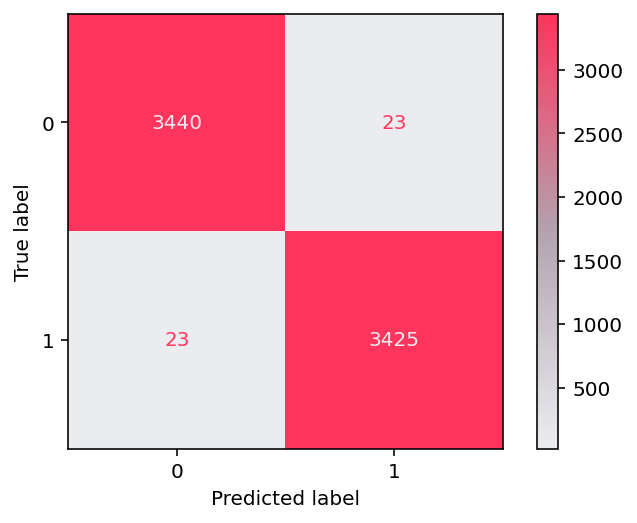

In [690]:
plot_confusion_matrix(svm_pipe_gs.best_estimator_, X_cont, y, cmap= pnkgry);

## Voting using classifiers with optimized hyperparameters

In [354]:
vote = VotingClassifier([('xgbc', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')),
    ('rfc', RandomForestClassifier()),
    ('logreg', LogisticRegression())],
  #  ('knn', KNeighborsClassifier())],
                       verbose = 1)

In [355]:
vote.fit(train_X_vec, train_y)
vote.score(train_X_vec, train_y)

[Voting] ..................... (1 of 3) Processing xgbc, total=   8.1s
[Voting] ...................... (2 of 3) Processing rfc, total=  22.8s
[Voting] ................... (3 of 3) Processing logreg, total=   0.3s


0.9789697086629365

In [356]:
vote.score(test_X_vec, test_y)

0.6863425925925926

In [576]:
vote = VotingClassifier([('SVM', svm_pipe_gs_best_estimator), 
                          ('RFC', rfc_pipe_gs_best_estimator), 
                          ('MNB', mnb_pipe_gs_best_estimator), 
                          ('XGBC', xgbc_pipe_gs_best_estimator), 
                          ('LOGR', logreg_pipe_gs_best_estimator)])
vote.fit(train_X, train_y)
vote.score(train_X, train_y)

0.9900506512301013

In [577]:
vote.score(test_X, test_y)

0.7295733911785972

**BRUTEFORCE VOTE from GS optimized estimators**

_This part can probably go now_

In [409]:
rfc_gs_best_params_est = RandomForestClassifier(bootstrap =  True, ccp_alpha = 0.0, criterion = 'gini', max_depth = 15, min_samples_leaf = 1, n_estimators = 125) 
# this is not optimized 

rfc_gs_best_params_est.fit(train_X_vec, train_y)

In [382]:
logreg_pipe_gs_best_params

{'logreg__C': 1.0,
 'tvec__max_df': 0.8,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None,
 'tvec__use_idf': True}

In [506]:
tfidf = TfidfVectorizer(max_df=  0.8, ngram_range= (1, 2), stop_words=  None, use_idf=  True)
logreg = LogisticRegression(C= 1.0)
logreg_pipe_gs_best_params_est = Pipeline(steps= [('tfidf', tfidf), ('logreg', logreg)])

#logreg_pipe_gs_best_params_est.fit(train_X, train_y)

In [505]:
xgbc_pipe_gs_best_params

{'tvec__max_df': 0.8,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None,
 'tvec__use_idf': False,
 'xgbc__gamma': 0.5,
 'xgbc__max_depth': 5,
 'xgbc__reg_lambda': 10.0}

In [407]:
tfidf = TfidfVectorizer(max_df=  0.8, ngram_range= (1, 2), stop_words=  None, use_idf=  False)
xgbc = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', gamma = 0.5, max_depth = 5, reg_lambda = 10.0)
xgbc_pipe_gs_best_params_est = Pipeline(steps= [('tfidf', tfidf), ('xgbc', xgbc)])

xgbc_pipe_gs_best_params_est.fit(train_X, train_y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, ngram_range=(1, 2),
                                 use_idf=False)),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0.0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1.7782794100389228,
                               scale_pos_weight=1, subsample=1,
                               tree_metho

In [510]:
#add svm_pipe_gs and rfc_pipe_gs when that's run

bruteforce_vote = pd.DataFrame(np.array([mnb_pipe_gs.best_estimator_.predict(X),logreg_pipe_gs.best_estimator_.predict(X), 
                                         xgbc_pipe_gs.best_estimator_.predict((X))]).T, 
                                        columns = ['mnb', 'logreg', 'xgbc'])
bruteforce_vote['sum_votes'] = bruteforce_vote['mnb'] + bruteforce_vote['logreg'] + bruteforce_vote['xgbc']
bruteforce_vote['prediction'] = bruteforce_vote['sum_votes'].apply(lambda x: 1 if x > bruteforce_vote.shape[1]/2 else 0)

In [512]:
accuracy_score(y, bruteforce_vote['prediction'])

0.8540008681811605

**_This is the good stuff_**

In [706]:
#with svm_pipe_gs and rfc_pipe_gs optimized "offline"

bruteforce_vote_all = pd.DataFrame(np.array([mnb_pipe_gs.best_estimator_.predict(X),logreg_pipe_gs.best_estimator_.predict(X), 
                                            xgbc_pipe_gs.best_estimator_.predict(X), svm_pipe_gs.best_estimator_.predict(X), 
                                            rfc_pipe_gs_best_estimator.predict(X)]).T, 
                                        columns = ['mnb', 'logreg', 'xgbc', 'svm', 'rfc'])
bruteforce_vote_all['sum_votes'] = bruteforce_vote_all['mnb'] + bruteforce_vote_all['logreg'] + bruteforce_vote_all['xgbc'] + bruteforce_vote_all['svm'] + bruteforce_vote_all['rfc']
bruteforce_vote_all['prediction'] = bruteforce_vote_all['sum_votes'].apply(lambda x: 1 if x > (bruteforce_vote_all.shape[1]-2)/2 else 0)

In [580]:
accuracy_score(y, bruteforce_vote_all['prediction'])

0.9463174649110114

In [ ]:
plot_confusion_matrix()

**This is reaching**

In [635]:
vote_gs = VotingClassifier([('svm', svm_pipe), 
                          ('rfc', rfc_pipe), 
                          ('mnb', mnb_pipe), 
                          ('xgbc', xgbc_pipe), 
                          ('logreg', logreg_pipe)])

In [656]:
vote_gs_params = {'svm__svm__C': np.array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
                                           1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
                                           2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
                                           3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ]),
               
                'svm__svm__degree': [1, 2, 3, 4],
                'svm__tvec__max_df': [0.8, 0.9, 1],
                'svm__tvec__ngram_range': [(1, 1), (1, 2)],
                'svm__tvec__stop_words': [None, 'english'],
                'svm__tvec__use_idf': [True, False],
                
                'rfc__rfc__max_features': [None, 10000, 5000],
                'rfc__rfc__min_samples_leaf': [1, 5, 10],
                'rfc__rfc__n_estimators': [5, 10, 15],
                'rfc__tvec__max_df': [0.8, 0.9, 1],
                'rfc__tvec__ngram_range': [(1, 1), (1, 2)],
                'rfc__tvec__stop_words': [None, 'english'],
                'rfc__tvec__use_idf': [True, False],
              
                'mnb__mnb__alpha': np.array([0.001  , 0.1, 0.25 , 0.5, 1.  ]),
                'mnb__tvec__max_df': [0.8, 0.9, 1],
                'mnb__tvec__ngram_range': [(1, 1), (1, 2)],
                'mnb__tvec__stop_words': [None, 'english'],
                'mnb__tvec__use_idf': [True, False],
              
                'xgbc__tvec__max_df': [0.8, 0.9, 1],
                'xgbc__tvec__ngram_range': [(1, 1), (1, 2)],
                'xgbc__tvec__stop_words': [None, 'english'],
                'xgbc__tvec__use_idf': [True, False],
                'xgbc__xgbc__gamma': np.array([0. , 0.5, 1. ]),
                'xgbc__xgbc__max_depth': [3, 4, 5],
                'xgbc__xgbc__reg_lambda': np.array([ 1.        ,  1.77827941,  3.16227766,  5.62341325, 10.        ]),
              
                'logreg__logreg__C': np.array([1.00000000e-08, 2.50000008e-01, 5.00000005e-01, 7.50000002e-01,
                                                   1.00000000e+00]),
                'logreg__tvec__max_df': [0.8, 0.9, 1],
                'logreg__tvec__ngram_range': [(1, 1), (1, 2)],
                'logreg__tvec__stop_words': [None, 'english'],
                'logreg__tvec__use_idf': [True, False]}

In [657]:
vote_gs_randopt = RandomizedSearchCV(vote_gs, vote_gs_params, verbose = 1, n_jobs=5)

In [661]:
vote_gs_randopt.best_score_

0.6744347582229115

In [665]:
vote_gs_randopt_best_params = {'xgbc__xgbc__reg_lambda': 1.0, 'xgbc__xgbc__max_depth': 4, 'xgbc__xgbc__gamma': 1.0, 'xgbc__tvec__use_idf': True, 'xgbc__tvec__stop_words': None, 'xgbc__tvec__ngram_range': (1, 1), 'xgbc__tvec__max_df': 0.9, 'svm__tvec__use_idf': False, 'svm__tvec__stop_words': 'english', 'svm__tvec__ngram_range': (1, 1), 'svm__tvec__max_df': 0.9, 'svm__svm__degree': 3, 'svm__svm__C': 4.47368421, 'rfc__tvec__use_idf': False, 'rfc__tvec__stop_words': None, 'rfc__tvec__ngram_range': (1, 1), 'rfc__tvec__max_df': 0.8, 'rfc__rfc__n_estimators': 5, 'rfc__rfc__min_samples_leaf': 10, 'rfc__rfc__max_features': None, 'mnb__tvec__use_idf': True, 'mnb__tvec__stop_words': 'english', 'mnb__tvec__ngram_range': (1, 1), 'mnb__tvec__max_df': 0.9, 'mnb__mnb__alpha': 0.0, 'logreg__tvec__use_idf': False, 'logreg__tvec__stop_words': None, 'logreg__tvec__ngram_range': (1, 1), 'logreg__tvec__max_df': 1, 'logreg__logreg__C': 0.250000008}

In [666]:
best_score = 0.6816680322250859
for i in range(10):
    vote_gs_randopt.fit(X,y)
    if vote_gs_randopt.best_score_ > best_score:
        best_score = vote_gs_randopt.best_score_
        best_est = vote_gs_randopt.best_estimator_
        print(best_score)
        print(vote_gs_randopt.best_params_)
        vote_gs_randopt_best_params = vote_gs_randopt.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  6.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.1min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  4.1min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  5.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  6.0min finished
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  5.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  5.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  4.6min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  5.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  7.7min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  6.8min finished


In [664]:
vote_gs_randopt.best_params_

{'xgbc__xgbc__reg_lambda': 3.16227766,
 'xgbc__xgbc__max_depth': 4,
 'xgbc__xgbc__gamma': 0.5,
 'xgbc__tvec__use_idf': True,
 'xgbc__tvec__stop_words': None,
 'xgbc__tvec__ngram_range': (1, 1),
 'xgbc__tvec__max_df': 0.8,
 'svm__tvec__use_idf': False,
 'svm__tvec__stop_words': None,
 'svm__tvec__ngram_range': (1, 2),
 'svm__tvec__max_df': 0.9,
 'svm__svm__degree': 2,
 'svm__svm__C': 3.15789474,
 'rfc__tvec__use_idf': False,
 'rfc__tvec__stop_words': 'english',
 'rfc__tvec__ngram_range': (1, 2),
 'rfc__tvec__max_df': 0.9,
 'rfc__rfc__n_estimators': 5,
 'rfc__rfc__min_samples_leaf': 5,
 'rfc__rfc__max_features': 5000,
 'mnb__tvec__use_idf': False,
 'mnb__tvec__stop_words': None,
 'mnb__tvec__ngram_range': (1, 1),
 'mnb__tvec__max_df': 0.9,
 'mnb__mnb__alpha': 0.5,
 'logreg__tvec__use_idf': True,
 'logreg__tvec__stop_words': None,
 'logreg__tvec__ngram_range': (1, 2),
 'logreg__tvec__max_df': 0.8,
 'logreg__logreg__C': 0.750000002}

# PART 5: Principal Component Analysis

**PYTHON IMPORTS!!!**

In [759]:
from mpl_toolkits.mplot3d import Axes3D

#### Retrieving data harvested in step 1, clened in step 2, and enhanced in step 3 from csv files to dataframes

In [192]:
AW_comments_df = pd.read_csv('aw_com.csv')
AW_posts_df = pd.read_csv('aw_pos.csv')
AM_comments_df = pd.read_csv('am_com.csv')
AM_posts_df = pd.read_csv('am_pos.csv')

#### Building X and y variables and performint train_test_split

In [517]:
X_cont = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), 
                    AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)


X_sent_emo = pd.concat([AW_posts_df[AW_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']], 
                        AW_comments_df[AW_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']],
                        AM_posts_df[AM_posts_df['title_selftext'].notna()][['sia_neg', 'sia_pos', 'senti_score','emojis']], 
                        AM_comments_df[AM_comments_df['body'].notna()][['sia_neg', 'sia_pos', 'senti_score', 'emojis']]], axis = 0)

X = pd.concat([X_cont, X_sent_emo], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_cont,y, test_size = 0.33, random_state = 11)

tvec.fit(X_train)

TfidfVectorizer()

In [518]:
logreg = LogisticRegression()
logreg.fit(tvec.fit_transform(X_train), y_train)

LogisticRegression()

#### 2-D visualization of real classes vs Principal Components

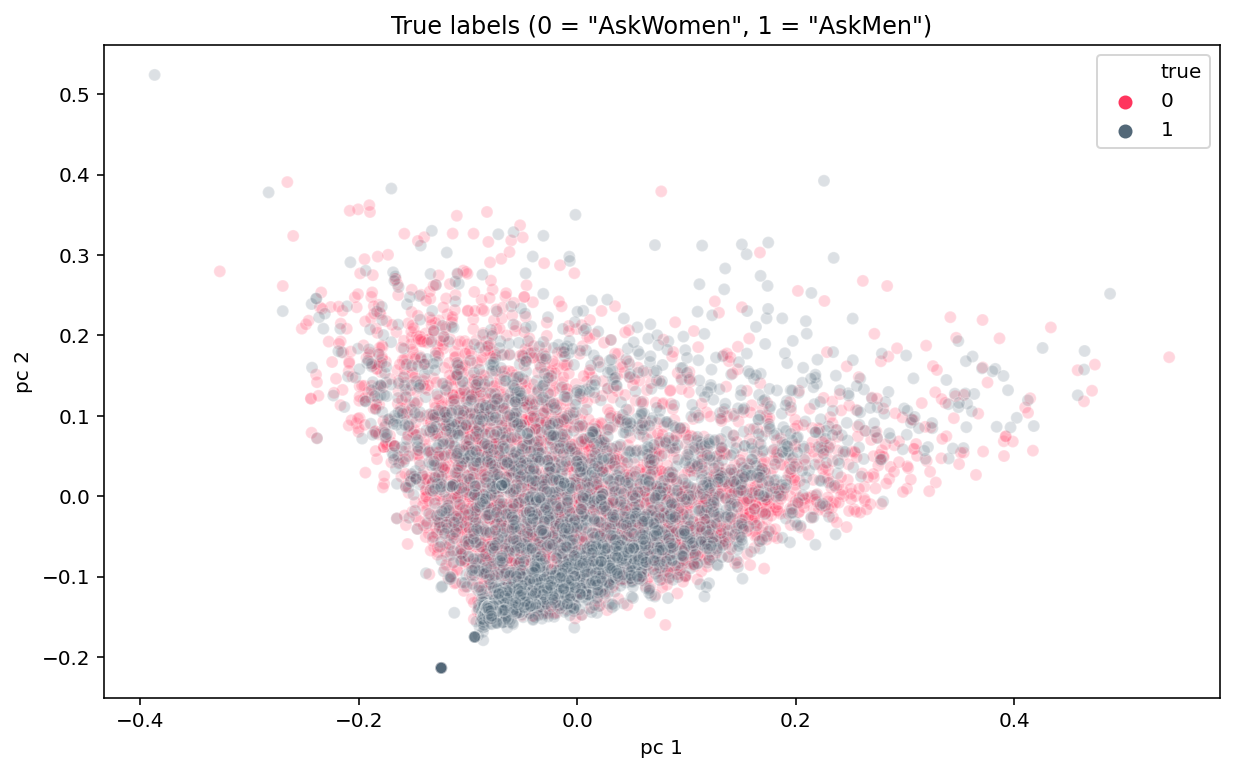

In [520]:
pca = PCA(n_components=2)
X_cont_vec = tvec.transform(X_cont)
pcomps = pca.fit_transform(pd.DataFrame(tvec.transform(X_cont).todense())) # only word vector
pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2'])

pcomps_df['true'] = y
#pcomps_df['logreg'] = logreg.predict(X_cont_vec)

plt.figure(figsize = (10,6))
plt.title('Principal Component Analysis for vectorized reddit entries')
plt.title('True labels (0 = "AskWomen", 1 = "AskMen")')
sns.scatterplot(data = pcomps_df, x = 'pc 1', y = 'pc 2', hue = 'true', alpha = 0.2, palette = ['#ff355e','#536878'])


plt.savefig('./visualizations/pca.png');

#### 2-D comparison of true and predicted classes vs Principal Components

In [744]:
models = ['baseline','xgbc', 'logreg','rfc', 'mnb','svm', 'bf_vote', 'ro_vote']
estimators = [None, xgbc_pipe_gs.best_estimator_, logreg_pipe_gs.best_estimator_, rfc_pipe_gs_best_estimator, mnb_pipe_gs.best_estimator_, 
              svm_pipe_gs.best_estimator_, None, None]
mod_est = {model: estimator for model, estimator in zip(models, estimators)}

In [756]:
def compare_true_predict_pca(model):
    if model in models:
        pca = PCA(n_components=2)
        X_cont_vec = tvec.transform(X_cont)
        pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
        pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2'])

        pcomps_df['true'] = y
        pcomps_df[model] = mod_est[model].predict(X_cont)

        plt.figure(figsize = (17,6))
        plt.suptitle('Principal Component Analysis for vectorized reddit entries')
        plt.subplot(1,2,1)
        plt.title('True labels (0 = "AskWomen", 1 = "AskMen")')
        sns.scatterplot(data = pcomps_df, x = 'pc 1', y = 'pc 2', hue = 'true', alpha = 0.2, palette = ['#ff355e','#536878'])

        plt.subplot(1,2,2)
        plt.title(f'Labels predicted by {model} model (0 = "AskWomen", 1 = "AskMen")')
        sns.scatterplot(data = pcomps_df, x = 'pc 1', y = 'pc 2', hue = model, alpha = 0.2, palette = ['#ff355e','#536878'])
    else:
        print('Please select a valid model from the list above')
#plt.savefig('./visualizations/pca2.png');

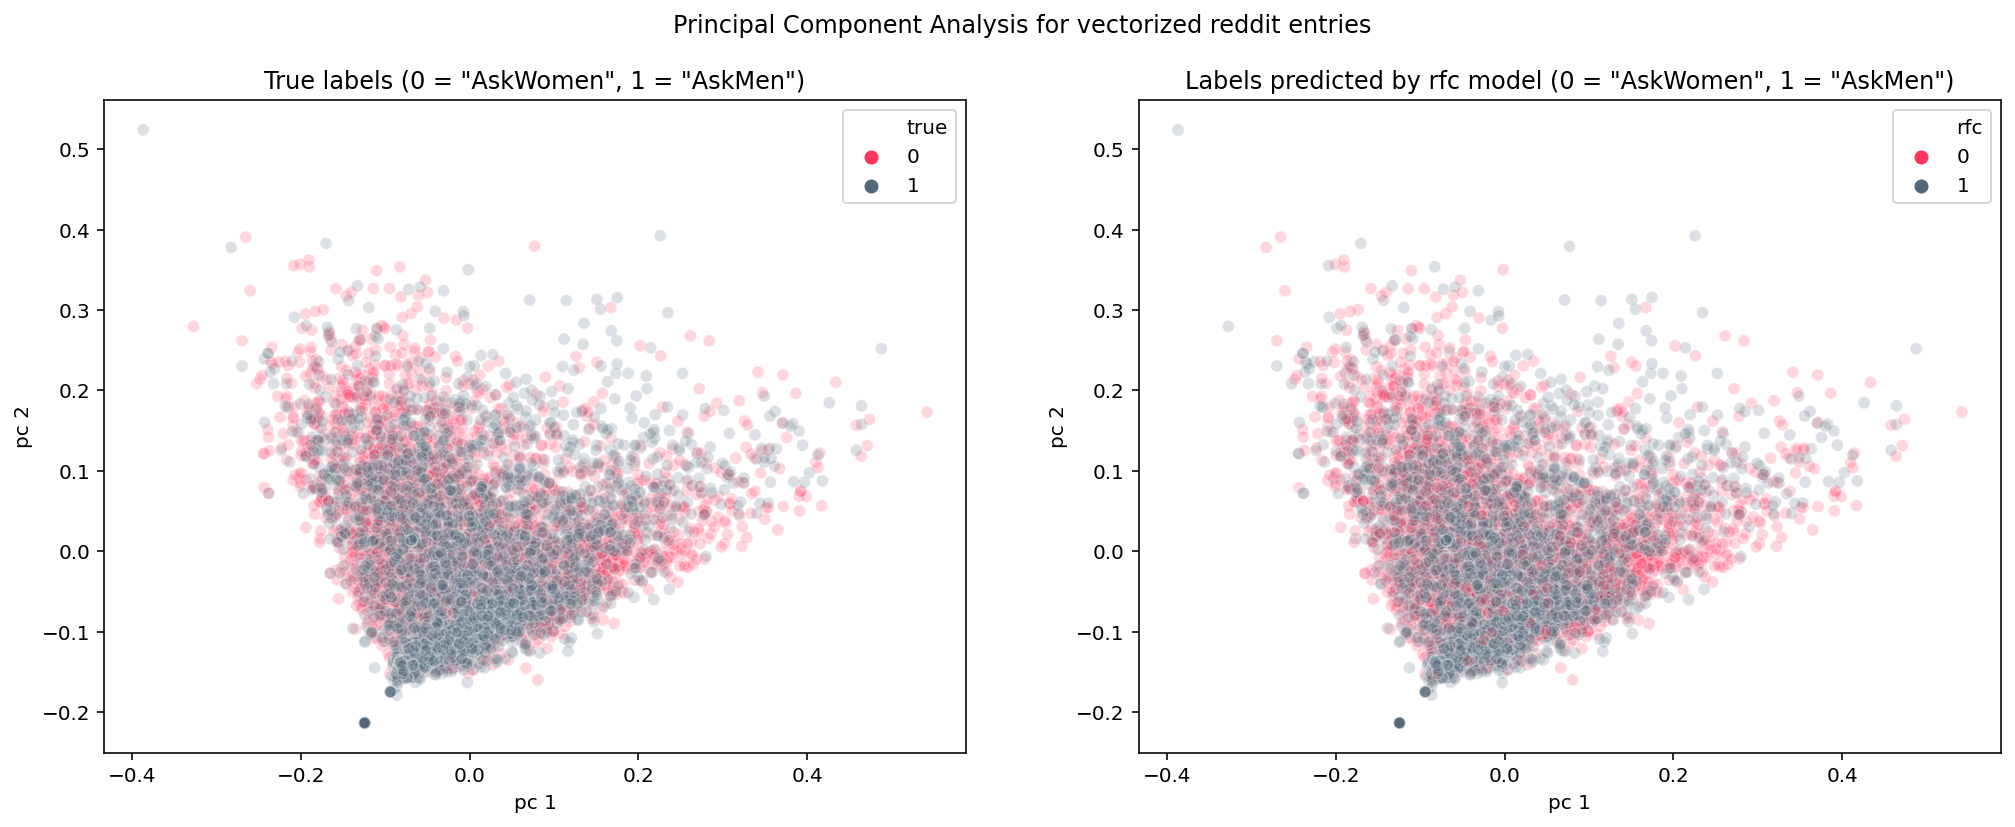

In [758]:
compare_true_predict_pca('rfc')

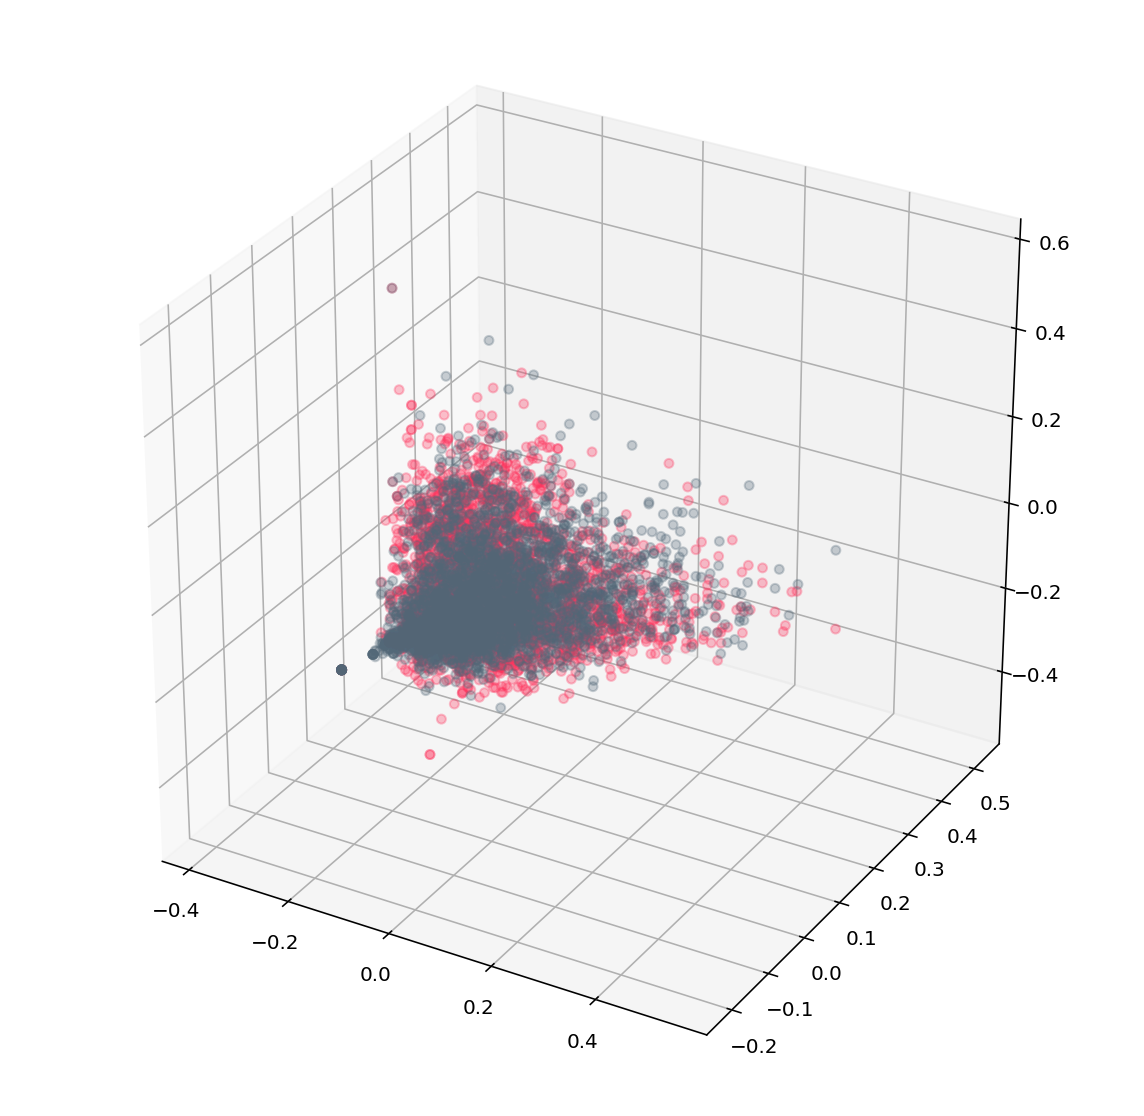

<Figure size 504x504 with 0 Axes>

In [534]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)
X_cont_vec = tvec.transform(X_cont)
pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2', 'pc 3'])
pcomps_df['true'] = y
pcomps_df['col_true'] = pcomps_df['true'].map({0: '#ff355e', 1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_true']);
plt.savefig('./visualizations/pca3d-true.png')

In [760]:
def pred_pca_3d(model):
    if model in models:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111, projection='3d')
        pca = PCA(n_components=3)
        X_cont_vec = tvec.transform(X_cont)
        pcomps = pca.fit_transform(pd.DataFrame(X_cont_vec.todense())) # only word vector
        pcomps_df = pd.DataFrame(data = pcomps, columns = ['pc 1', 'pc 2', 'pc 3'])
        pcomps_df[model] = mod_est[model].predict(X_cont)
        pcomps_df['col_pred'] = pcomps_df[model].map({0: '#ff355e',  1: '#536878'})
        
        plt.figure(figsize = (7,7))
        ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_pred']);

    else:
            print('Please select a valid model from the list above')
#plt.savefig('./visualizations/pca3d-logreg.png')

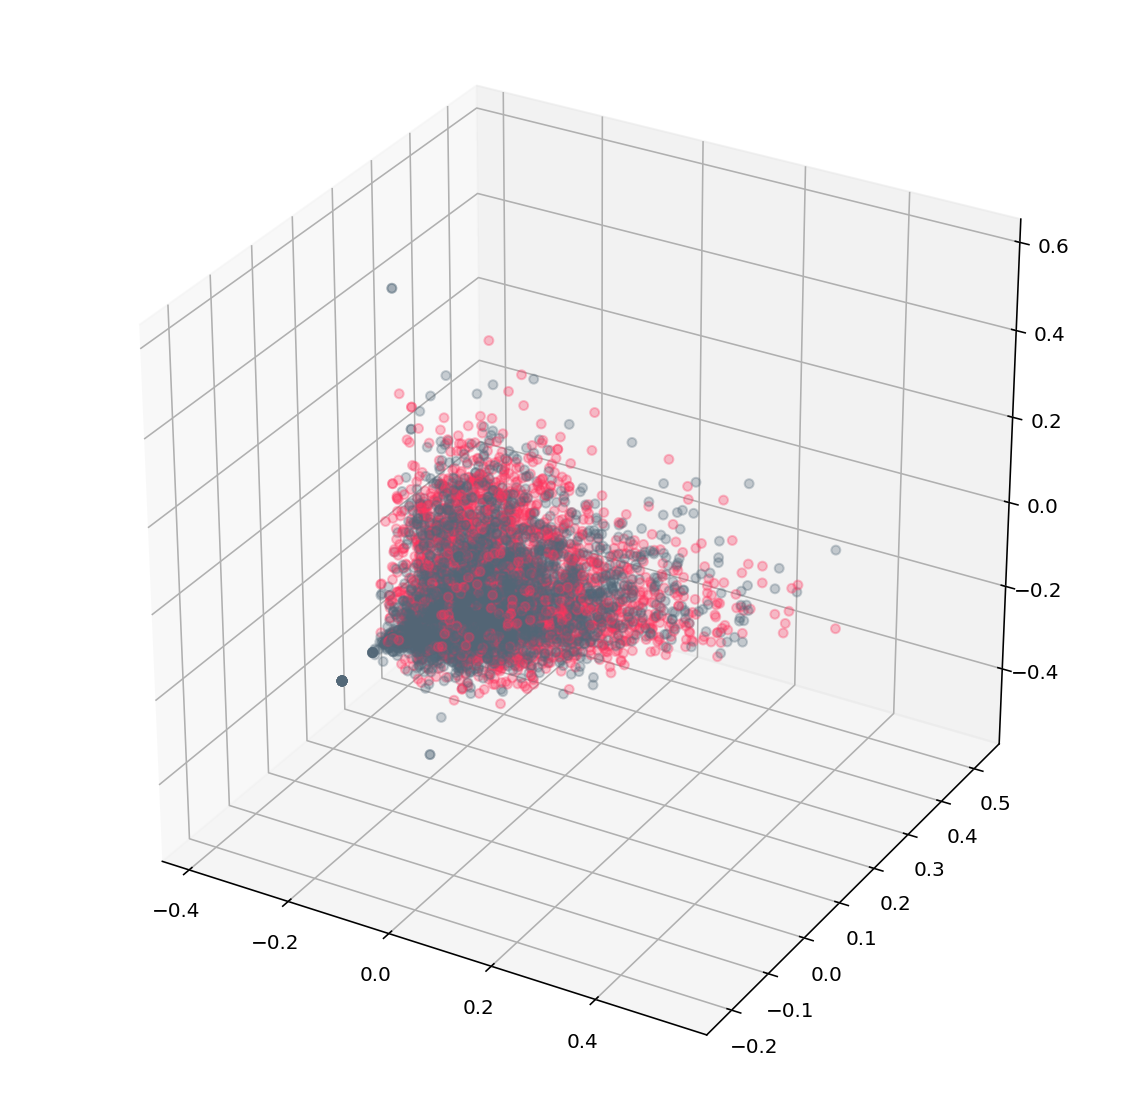

<Figure size 504x504 with 0 Axes>

In [761]:
pred_pca_3d('logreg')

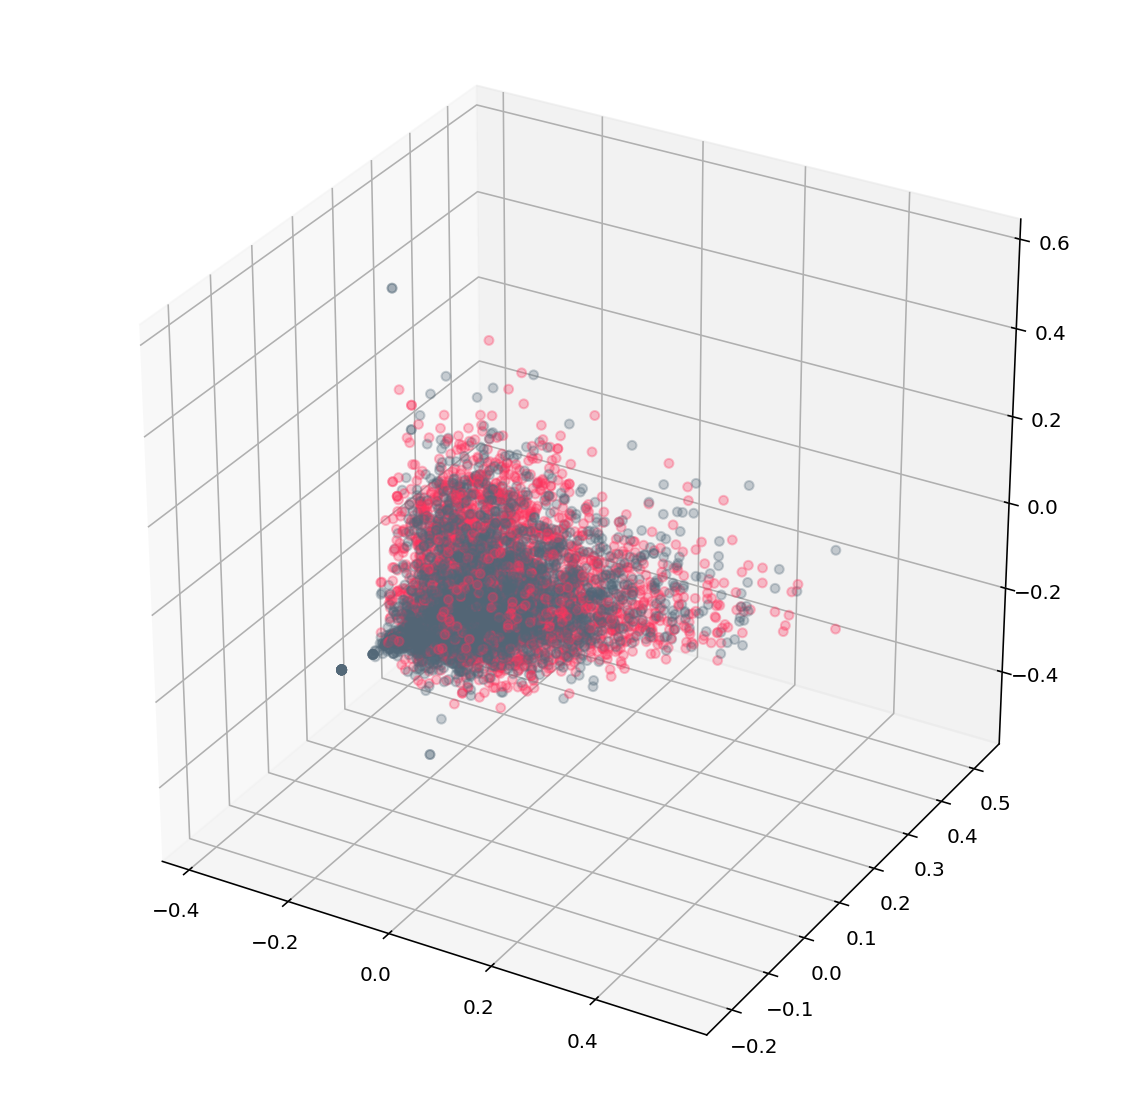

<Figure size 504x504 with 0 Axes>

In [535]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_logreg']);

plt.savefig('./visualizations/pca3d-logreg.png')

In [447]:
knn = KNeighborsClassifier()
knn.fit(tvec.fit_transform(X_train), y_train)

KNeighborsClassifier()

In [530]:
X_cont.shape

(6911,)

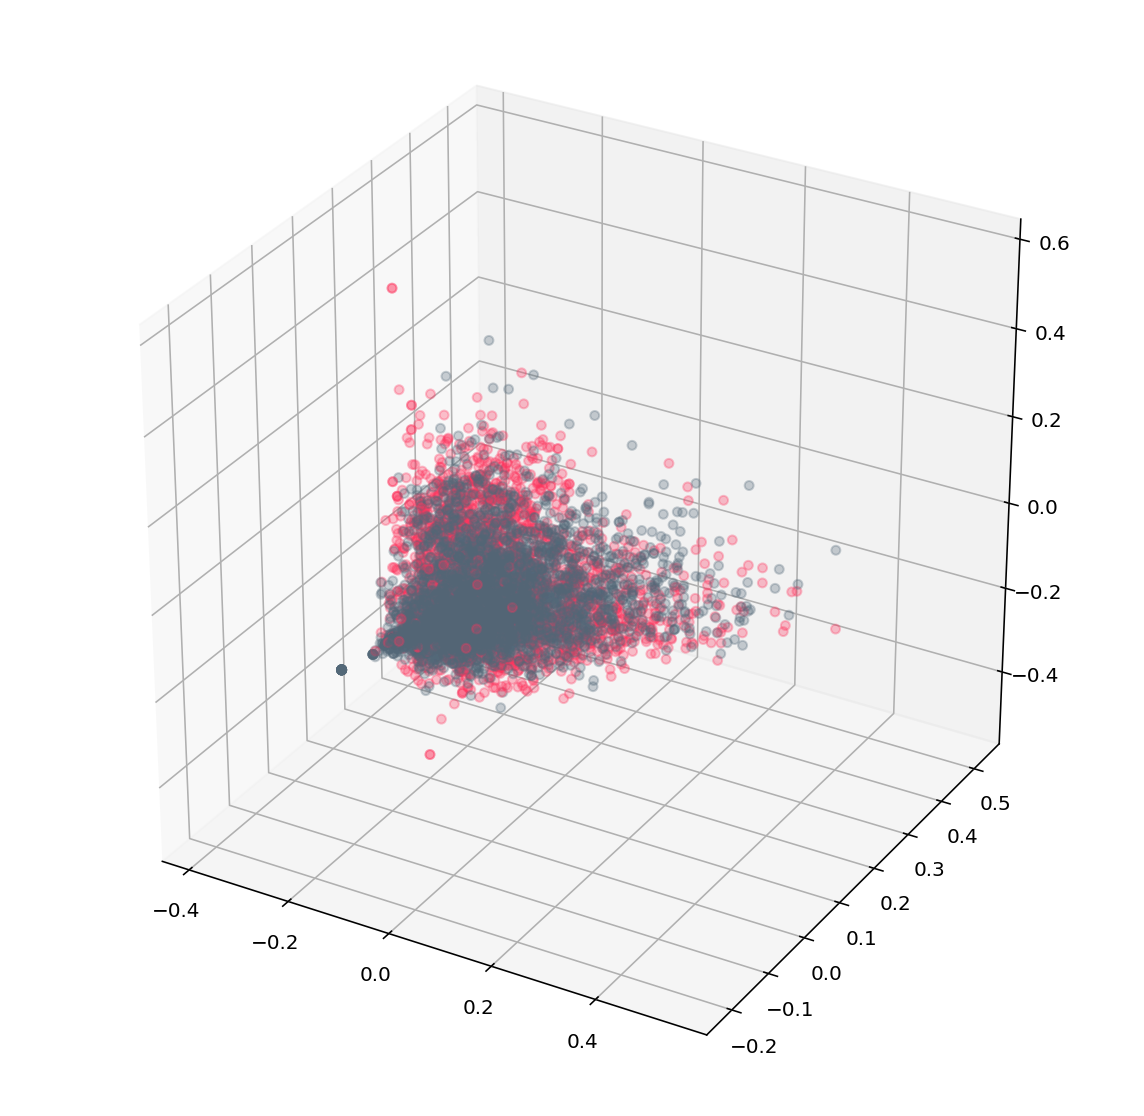

<Figure size 504x504 with 0 Axes>

In [536]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pcomps_df['mnb'] = mnb_pipe_gs.best_estimator_.predict(X_cont)
pcomps_df['col_mnb'] = pcomps_df['mnb'].map({0: '#ff355e',  1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_mnb']);

plt.savefig('./visualizations/pca3d-mnb.png')

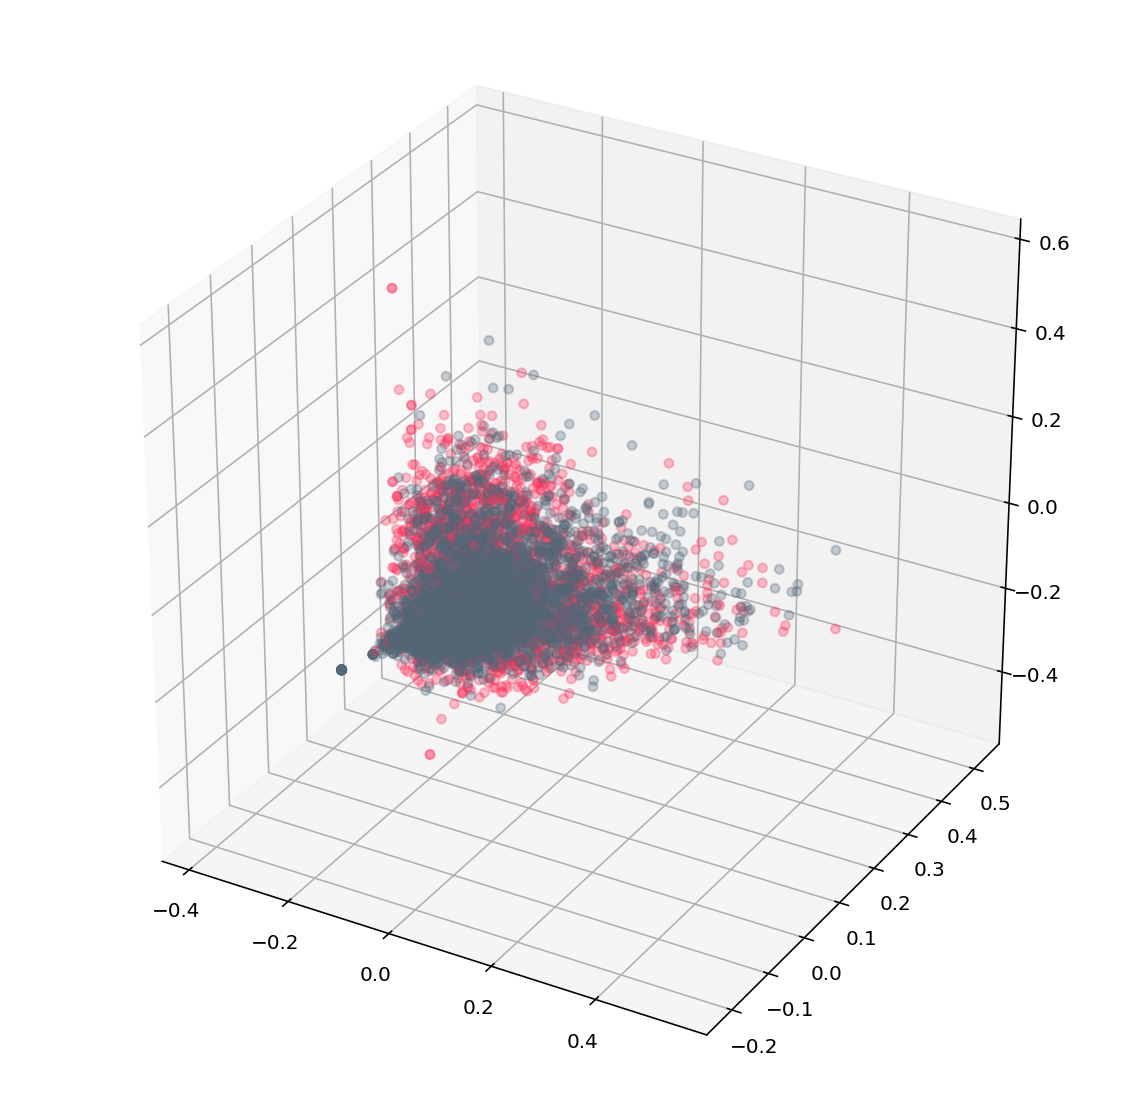

<Figure size 504x504 with 0 Axes>

In [669]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pcomps_df['svm'] = svm_pipe_gs.best_estimator_.predict(X_cont)
pcomps_df['col_svm'] = pcomps_df['svm'].map({0: '#ff355e',  1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_svm']);

plt.savefig('./visualizations/pca3d-svm.png')

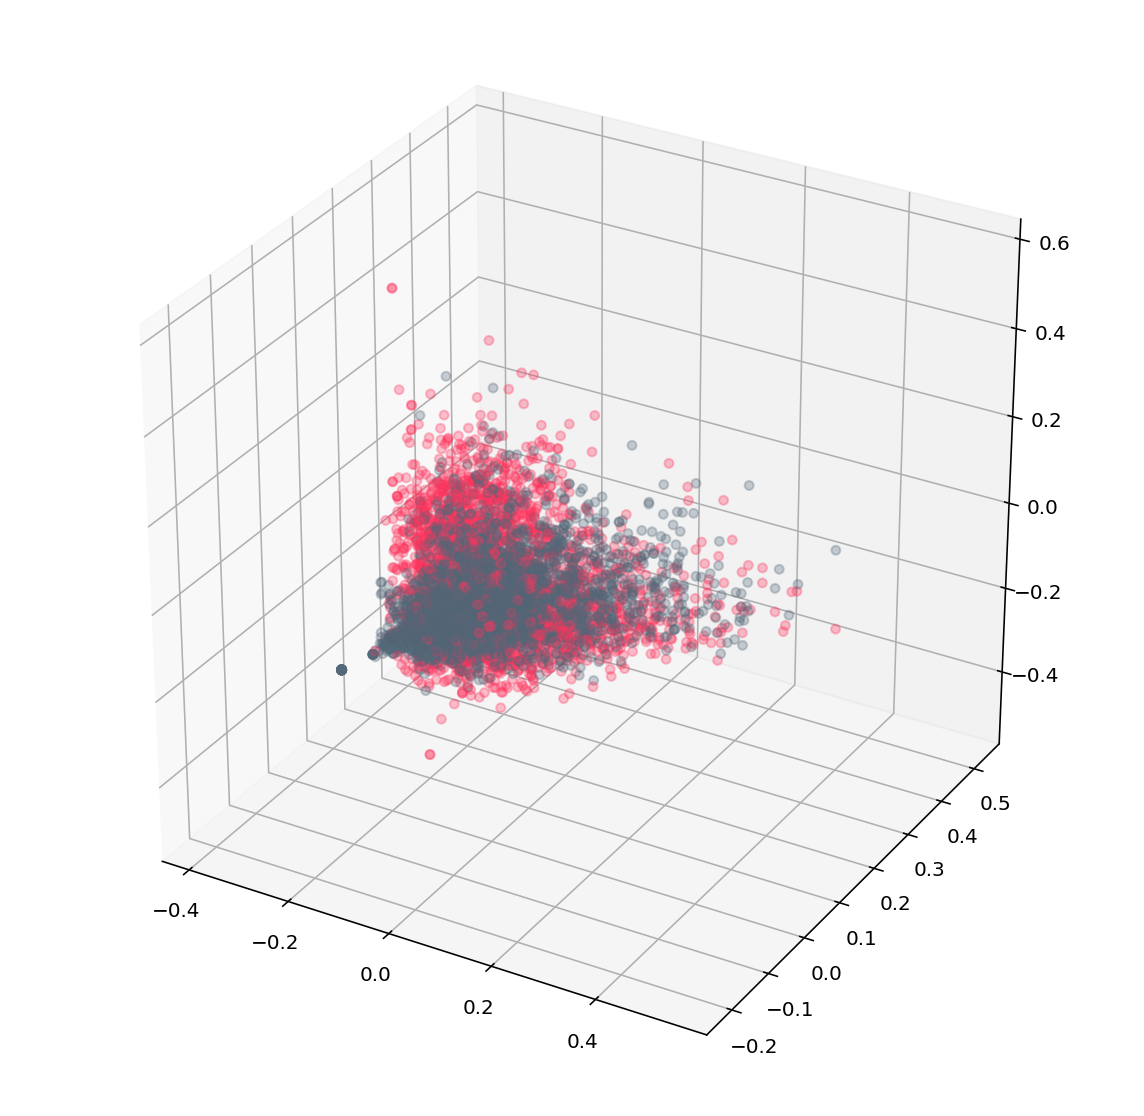

<Figure size 504x504 with 0 Axes>

In [538]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pcomps_df['xgbc'] = xgbc_pipe_gs.best_estimator_.predict(X_cont)
pcomps_df['col_xgbc'] = pcomps_df['xgbc'].map({0: '#ff355e',  1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_xgbc']);

plt.savefig('./visualizations/pca3d-xgbc.png')

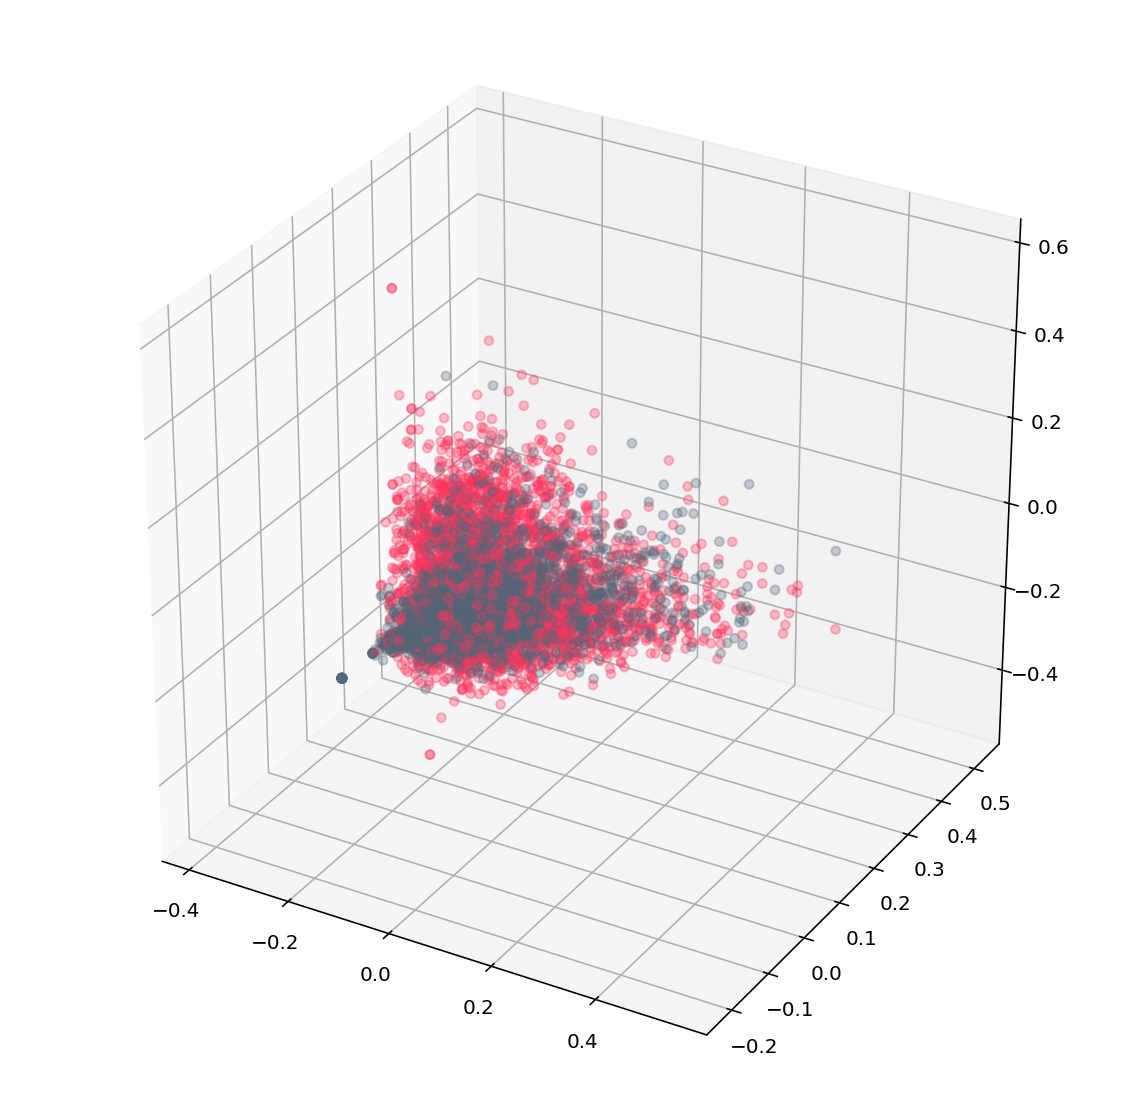

<Figure size 504x504 with 0 Axes>

In [525]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pcomps_df['bruteforce_vote'] = bruteforce_vote['prediction']
pcomps_df['col_bv'] = pcomps_df['bruteforce_vote'].map({0: '#ff355e',  1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_bv']);

plt.savefig('./visualizations/pca3d-bv.png')

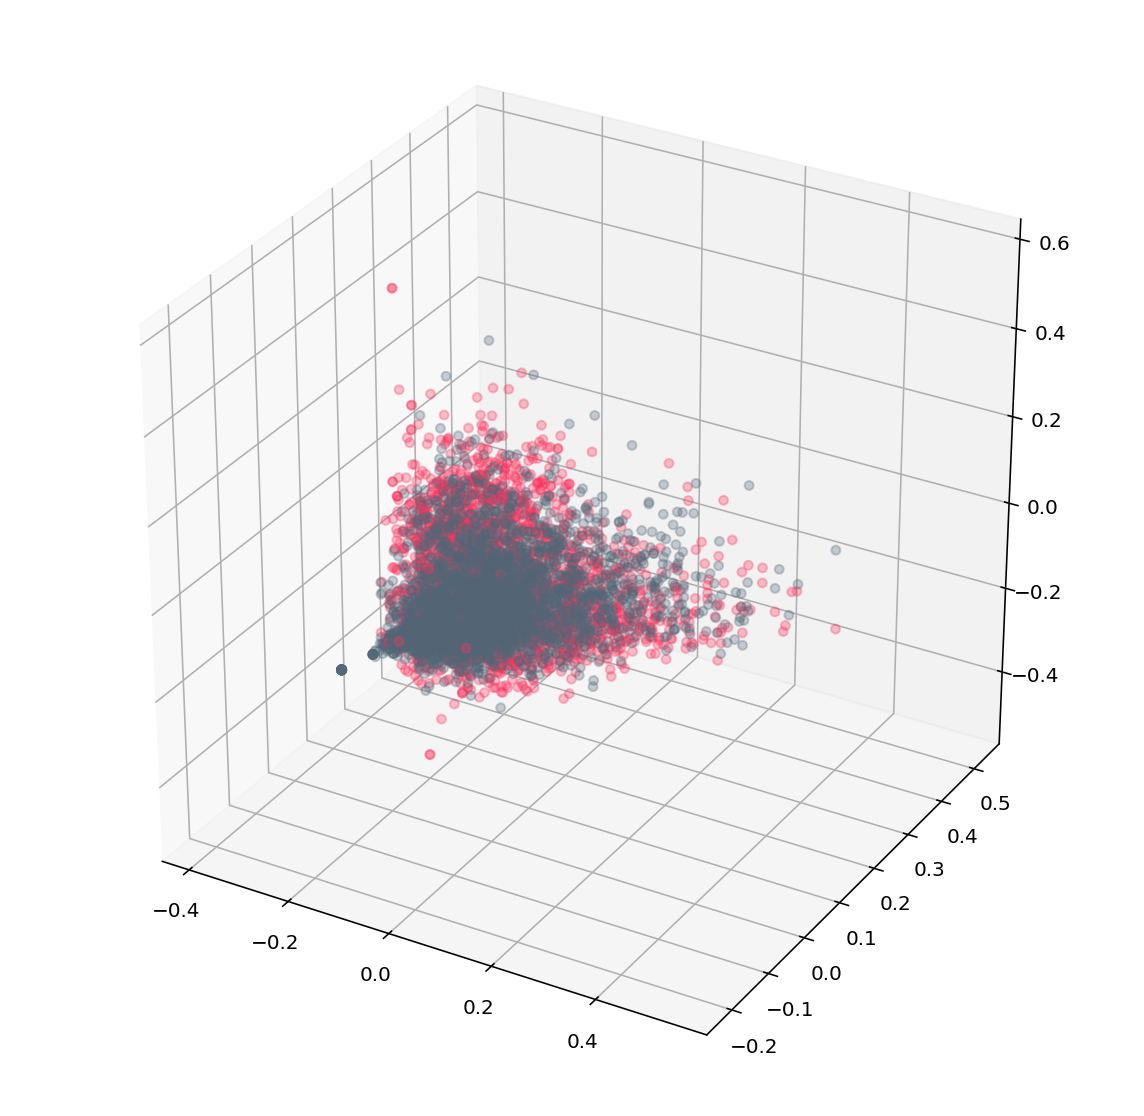

<Figure size 504x504 with 0 Axes>

In [674]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

pcomps_df['vote_gs_ro'] = vote_gs_randopt.best_estimator_.predict(X_cont)
pcomps_df['col_vote_gs_ro'] = pcomps_df['vote_gs_ro'].map({0: '#ff355e',  1: '#536878'})

plt.figure(figsize = (7,7))
ax.scatter(xs = pcomps_df['pc 1'], ys = pcomps_df['pc 2'], zs = pcomps_df['pc 3'], alpha = 0.3,  c = pcomps_df['col_vote_gs_ro']);

plt.savefig('./visualizations/pca3d-vote-gs.png')

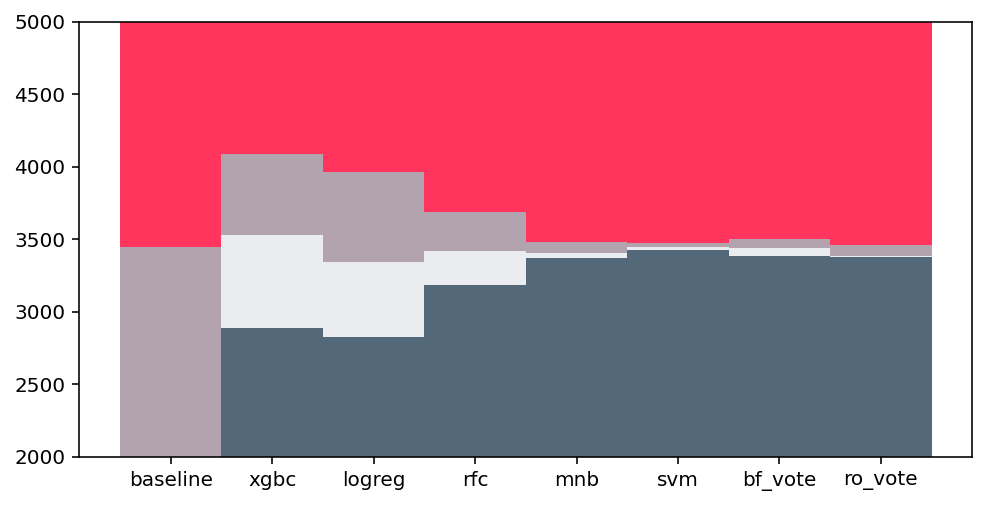

In [726]:
models = ['baseline','xgbc', 'logreg','rfc', 'mnb','svm', 'bf_vote', 'ro_vote']
summary = pd.DataFrame(columns = models, 
                            index = ['tn', 'fp', 'fn', 'tp'],
                            data = np.array([confusion_matrix(y,baseline_model(X_cont,y)).ravel(),
                                            confusion_matrix(y, xgbc_pipe_gs.best_estimator_.predict(X_cont)).ravel(),
                                            confusion_matrix(y, logreg_pipe_gs.best_estimator_.predict(X_cont)).ravel(),
                                            confusion_matrix(y, rfc_pipe_gs_best_estimator.predict(X_cont)).ravel(),
                                            confusion_matrix(y, mnb_pipe_gs.best_estimator_.predict(X_cont)).ravel(),
                                            confusion_matrix(y, svm_pipe_gs.best_estimator_.predict(X_cont)).ravel(),
                                            confusion_matrix(y, bruteforce_vote_all['prediction']).ravel(),
                                            confusion_matrix(y, vote_gs_randopt.best_estimator_.predict(X_cont)).ravel()]).T)

plt.figure(figsize = (8,4))
plt.bar(models, summary.T['tp'], width = 1, color = ['#536878'])
plt.bar(models, summary.T['fp'], bottom = summary.T['tp'], width = 1, color = ['#EBECF0'])
plt.bar(models, summary.T['fn'], bottom = summary.T['fp']+ summary.T['tp'], width = 1, color = ['#b2a3af'])
plt.bar(models, summary.T['tn'], bottom = summary.T['tp']+ summary.T['fp']+ summary.T['fn'], width = 1, color = ['#ff355e'])
plt.ylim(2000,5000);

In [738]:
print(f"BASE: ")
print(f"XGBC: {xgbc_pipe_gs.best_score_}")
print(f"LogReg: {logreg_pipe_gs.best_score_}")
print(f"RFC: {cross_val_score(rfc_pipe_gs_best_estimator,X_cont,y).mean()}")
print(f"MNB: {mnb_pipe_gs.best_score_}")
print(f"SVM: {svm_pipe_gs.best_score_}")
print(f"BFV: ")
print(f"ROV: {vote_gs_randopt.best_score_}")

BASE: 
XGBC: 0.6699378330837658
LogReg: 0.6515714385870186
RFC: 0.632036209795815
MNB: 0.6664790462647007
SVM: 0.6779008698764091
BFV: 
ROV: 0.6764588192576175


In [732]:
print(f"BASE: {accuracy_score(y_train, baseline_model(X_train, y_train))}")
print(f"XGBC: {accuracy_score(y_train, xgbc_pipe_gs.best_estimator_.predict(X_train))}")
print(f"LogReg: {accuracy_score(y_train, logreg_pipe_gs.best_estimator_.predict(X_train))}")
print(f"RFC: {accuracy_score(y_train, rfc_pipe_gs_best_estimator.predict(X_train))}")
print(f"MNB: {accuracy_score(y_train, mnb_pipe_gs.best_estimator_.predict(X_train))}")
print(f"SVM: {accuracy_score(y_train, svm_pipe_gs.best_estimator_.predict(X_train))}")
print(f"BFV: ")
print(f"ROV: {accuracy_score(y_train, vote_gs_randopt.best_estimator_.predict(X_train))}")

XGBC: 0.8237580993520518
LogReg: 0.8315334773218143
RFC: 0.9302375809935205
MNB: 0.9840172786177106
SVM: 0.9928725701943845


In [741]:
print(f"BASE: {accuracy_score(y_test, baseline_model(X_train, y_test))}")
print(f"XGBC: {accuracy_score(y_test, xgbc_pipe_gs.best_estimator_.predict(X_test))}")
print(f"LogReg: {accuracy_score(y_test, logreg_pipe_gs.best_estimator_.predict(X_test))}")
print(f"RFC: {accuracy_score(y_test, rfc_pipe_gs_best_estimator.predict(X_test))}")
print(f"MNB: {accuracy_score(y_test, mnb_pipe_gs.best_estimator_.predict(X_test))}")
print(f"SVM: {accuracy_score(y_test, svm_pipe_gs.best_estimator_.predict(X_test))}")
print(f"BFV: ")
print(f"ROV: {accuracy_score(y_test, vote_gs_randopt.best_estimator_.predict(X_test))}")

BASE: 0.5063568610258659
XGBC: 0.8316527838667251
LogReg: 0.841297676457694
RFC: 0.9224024550635687
MNB: 0.9846558526961858
SVM: 0.9943007452871547
BFV: 
ROV: 0.9881630863656291
